## RandAugmentation_simple
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [1]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

if "./" not in sys.path:
    sys.path.append("./")

In [2]:
from src.model import Model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion

In [3]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

DATASET_DIR = "./input/cifar10"     # cifar10의 디렉토리 주소(baseline에 x) 

In [4]:
def generate_transform(resize: int = 32, aug_fcns: Tuple = ()) -> transforms.transforms.Compose:   # size = 32x32, augmentation = 튜플로 묶음음, Compose로 처리
    """Generate train augmentation policy."""
    transform_fcns = []
    transform_fcns.append(transforms.Resize((resize, resize)))
    transform_fcns += list(aug_fcns)
    
    transform_fcns.append(transforms.ToTensor())
    transform_fcns.append(transforms.Normalize(MEAN_V, STD_V))
    
    return transforms.Compose(transform_fcns)
    

In [10]:
generate_transform.__dir__dd

<function function.__dir__()>

In [5]:
def load_cifar10(img_size: int = 32, 
                 aug_fcns: Tuple = (), 
                 validation_ratio: float = 0.8,
                ) -> Tuple[CIFAR10, CIFAR10, CIFAR10]:
    tf_train = generate_transform(resize=img_size, aug_fcns=aug_fcns)
    tf_test = generate_transform(resize=img_size)
    
    train_dataset = CIFAR10(root=DATASET_DIR, train=True, download=True, transform=tf_train)
    train_length = int(len(train_dataset) * validation_ratio)
    val_length = len(train_dataset) - train_length

    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    test_dataset = CIFAR10(root=DATASET_DIR, train=False, download=True, transform=tf_test)
    
    return train_dataset, val_dataset, test_dataset
    

In [6]:
def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset: CIFAR10, _val_dataset: CIFAR10, _test_dataset: CIFAR10, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(_val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

In [7]:
import optuna
import yaml

In [8]:
EPOCHS = 10
BATCH_SIZE = 256
    
def objective(trial: optuna.Trial) -> float:
    img_size = 32

    augmentation_functions = []
    use_color_jitter = trial.suggest_categorical("aug_color_jitter", [True, False])
    use_random_perspective = trial.suggest_categorical("aug_random_perspective", [True, False])
    use_random_flip = trial.suggest_categorical("aug_random_flip", [True, False])
    
    if use_color_jitter:
        augmentation_functions.append(transforms.ColorJitter(brightness=(0.5, 1.5), 
                                                             contrast=(0.5, 1.5), 
                                                             saturation=(0.5, 1.5)))
    if use_random_perspective:
        augmentation_functions.append(transforms.RandomPerspective())
    
    if use_random_flip:
        augmentation_functions.append(transforms.RandomHorizontalFlip())
    
        
    train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, 
                                                            aug_fcns = tuple(augmentation_functions), 
                                                            validation_ratio=0.8)
    
    visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix=f"Trial {trial.number:03d} //")
    plt.draw()
    plt.show()
    print(augmentation_functions)
    
    with open("./configs/model/mobilenetv3.yaml", "r") as f:
        model_cfg = yaml.load(f, yaml.SafeLoader)

    model_cfg['backbone'][-1][-1] = [10]

    model = Model(model_cfg, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
    criterion = CustomCriterion(samples_per_cls=None, device=device)

    train_loader = DataLoader(dataset=train_dataset, 
                              pin_memory=torch.cuda.is_available(), 
                              shuffle=True, 
                              batch_size=BATCH_SIZE, 
                              num_workers=4, 
                              drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, 
                            pin_memory=torch.cuda.is_available(), 
                            shuffle=False, 
                            batch_size=BATCH_SIZE, 
                            num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, 
                             pin_memory=torch.cuda.is_available(), 
                             shuffle=False, 
                             batch_size=BATCH_SIZE, 
                             num_workers=4)

    exp_dir = "./exp/autoaug"
    os.makedirs(exp_dir, exist_ok=True)
    trainer = TorchTrainer(model=model, 
                           criterion=criterion, 
                           optimizer=optimizer, 
                           scheduler=scheduler, 
                           device=device, 
                           verbose=1, 
                           model_path=os.path.join(exp_dir, "best.pt"))

    best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                      n_epoch=EPOCHS, 
                                      val_dataloader=val_loader)
    print("TEST DATASET")
    test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)
    
    return test_f1

[I 2021-11-24 06:28:34,688] A new study created in memory with name: autoaug


0it [00:00, ?it/s]

Extracting ./input/cifar10/cifar-10-python.tar.gz to ./input/cifar10
Files already downloaded and verified


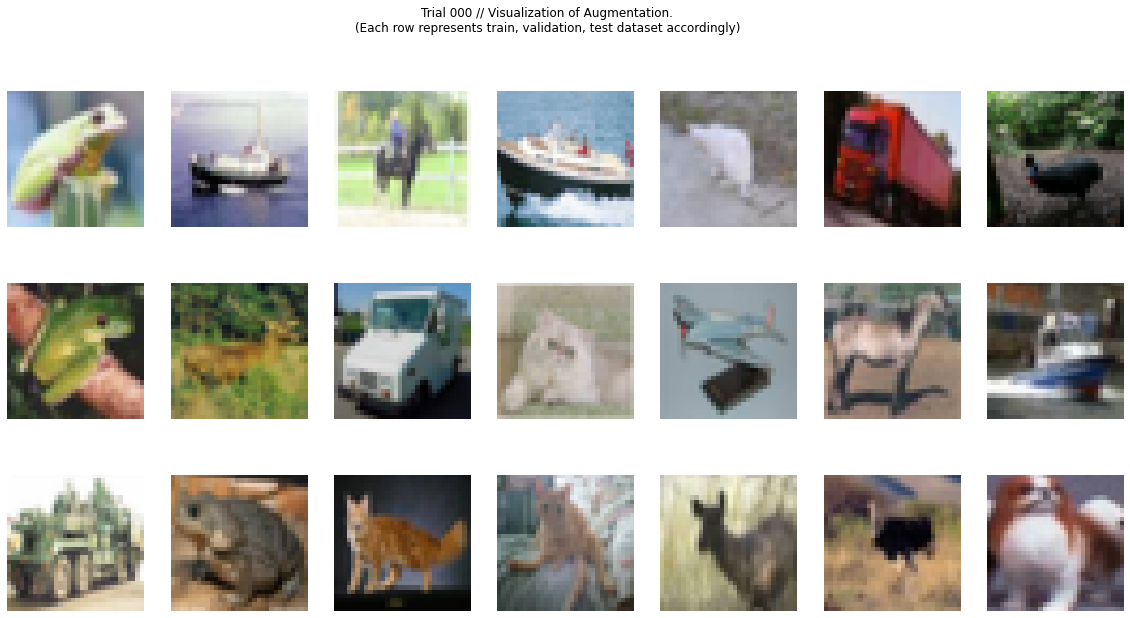

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.973, Acc: 27.29% F1(macro): 0.27: 100%|██████████| 156/156 [00:11<00:00, 14.03it/s]
 Val:       Loss: 1.683, Acc: 38.00% F1(macro): 0.36: 100%|██████████| 40/40 [00:01<00:00, 36.86it/s]


Model saved. Current best test f1: 0.360


Train: [002] Loss: 1.531, Acc: 43.97% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.89it/s]
 Val:       Loss: 1.451, Acc: 46.51% F1(macro): 0.46: 100%|██████████| 40/40 [00:01<00:00, 35.98it/s]


Model saved. Current best test f1: 0.459


Train: [003] Loss: 1.378, Acc: 49.86% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 14.56it/s]
 Val:       Loss: 1.381, Acc: 50.01% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 37.59it/s]


Model saved. Current best test f1: 0.498


Train: [004] Loss: 1.279, Acc: 53.68% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 14.53it/s]
 Val:       Loss: 1.339, Acc: 52.81% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 39.41it/s]


Model saved. Current best test f1: 0.516


Train: [005] Loss: 1.209, Acc: 56.56% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.50it/s]
 Val:       Loss: 1.254, Acc: 55.11% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 36.31it/s]


Model saved. Current best test f1: 0.547


Train: [006] Loss: 1.133, Acc: 59.29% F1(macro): 0.59: 100%|██████████| 156/156 [00:10<00:00, 14.64it/s]
 Val:       Loss: 1.202, Acc: 56.95% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 36.48it/s]


Model saved. Current best test f1: 0.559


Train: [007] Loss: 1.078, Acc: 61.17% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 14.76it/s]
 Val:       Loss: 1.170, Acc: 59.01% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 38.82it/s]


Model saved. Current best test f1: 0.581


Train: [008] Loss: 1.020, Acc: 63.28% F1(macro): 0.63: 100%|██████████| 156/156 [00:10<00:00, 14.54it/s]
 Val:       Loss: 1.124, Acc: 59.95% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 35.84it/s]


Model saved. Current best test f1: 0.600


Train: [009] Loss: 0.974, Acc: 65.13% F1(macro): 0.65: 100%|██████████| 156/156 [00:10<00:00, 14.47it/s]
 Val:       Loss: 1.100, Acc: 60.67% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 39.42it/s]


Model saved. Current best test f1: 0.603


Train: [010] Loss: 0.930, Acc: 66.91% F1(macro): 0.67: 100%|██████████| 156/156 [00:11<00:00, 14.10it/s]
 Val:       Loss: 1.080, Acc: 62.35% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 37.99it/s]


Model saved. Current best test f1: 0.618
TEST DATASET


 Val:       Loss: 1.103, Acc: 61.38% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 39.50it/s]
[I 2021-11-24 06:31:04,863] Trial 0 finished with value: 0.6066051865668722 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 0 with value: 0.6066051865668722.


Files already downloaded and verified
Files already downloaded and verified


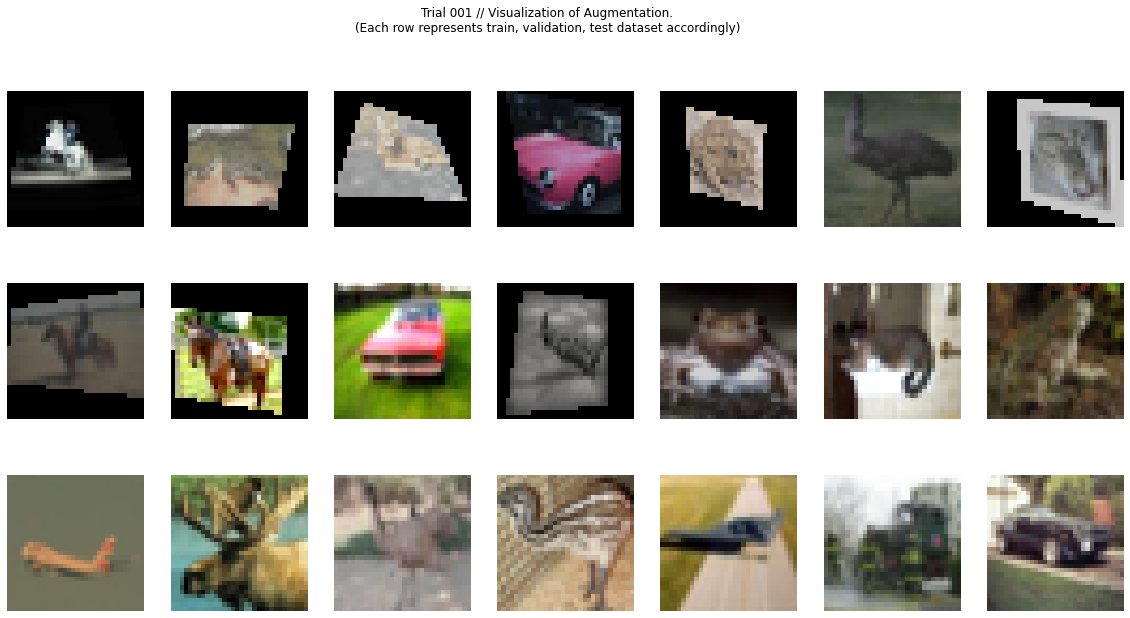

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,

Train: [001] Loss: 2.151, Acc: 19.07% F1(macro): 0.18: 100%|██████████| 156/156 [00:11<00:00, 14.13it/s]
 Val:       Loss: 1.955, Acc: 28.41% F1(macro): 0.26: 100%|██████████| 40/40 [00:02<00:00, 17.93it/s]


Model saved. Current best test f1: 0.262


Train: [002] Loss: 1.857, Acc: 30.85% F1(macro): 0.30: 100%|██████████| 156/156 [00:11<00:00, 13.89it/s]
 Val:       Loss: 1.793, Acc: 33.62% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 17.18it/s]


Model saved. Current best test f1: 0.327


Train: [003] Loss: 1.730, Acc: 36.74% F1(macro): 0.36: 100%|██████████| 156/156 [00:11<00:00, 13.94it/s]
 Val:       Loss: 1.738, Acc: 37.73% F1(macro): 0.37: 100%|██████████| 40/40 [00:02<00:00, 17.79it/s]


Model saved. Current best test f1: 0.366


Train: [004] Loss: 1.637, Acc: 40.43% F1(macro): 0.40: 100%|██████████| 156/156 [00:11<00:00, 13.82it/s]
 Val:       Loss: 1.609, Acc: 41.60% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 17.64it/s]


Model saved. Current best test f1: 0.408


Train: [005] Loss: 1.569, Acc: 42.92% F1(macro): 0.42: 100%|██████████| 156/156 [00:11<00:00, 13.64it/s]
 Val:       Loss: 1.567, Acc: 42.28% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s]


Model saved. Current best test f1: 0.414


Train: [006] Loss: 1.525, Acc: 44.75% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 13.83it/s]
 Val:       Loss: 1.525, Acc: 44.90% F1(macro): 0.44: 100%|██████████| 40/40 [00:02<00:00, 14.99it/s]


Model saved. Current best test f1: 0.437


Train: [007] Loss: 1.489, Acc: 46.14% F1(macro): 0.46: 100%|██████████| 156/156 [00:11<00:00, 13.85it/s]
 Val:       Loss: 1.488, Acc: 47.05% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 17.45it/s]


Model saved. Current best test f1: 0.465


Train: [008] Loss: 1.450, Acc: 47.76% F1(macro): 0.47: 100%|██████████| 156/156 [00:11<00:00, 14.06it/s]
 Val:       Loss: 1.421, Acc: 48.72% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s]


Model saved. Current best test f1: 0.482


Train: [009] Loss: 1.410, Acc: 49.15% F1(macro): 0.49: 100%|██████████| 156/156 [00:11<00:00, 13.53it/s]
 Val:       Loss: 1.434, Acc: 48.02% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 17.95it/s]
Train: [010] Loss: 1.388, Acc: 50.25% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 13.91it/s]
 Val:       Loss: 1.376, Acc: 50.14% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 17.53it/s]


Model saved. Current best test f1: 0.498
TEST DATASET


 Val:       Loss: 1.238, Acc: 55.26% F1(macro): 0.55: 100%|██████████| 40/40 [00:00<00:00, 41.53it/s]
[I 2021-11-24 06:33:33,998] Trial 1 finished with value: 0.5464956149183811 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 0 with value: 0.6066051865668722.


Files already downloaded and verified
Files already downloaded and verified


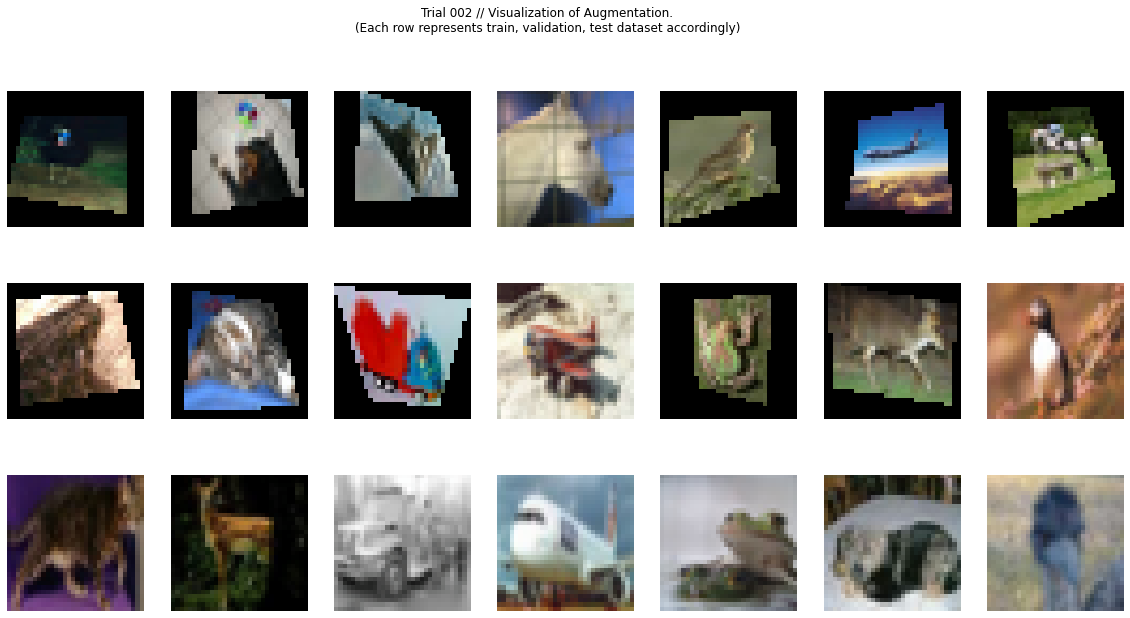

[RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           4

Train: [001] Loss: 2.075, Acc: 22.86% F1(macro): 0.22: 100%|██████████| 156/156 [00:10<00:00, 14.62it/s]
 Val:       Loss: 1.877, Acc: 31.98% F1(macro): 0.30: 100%|██████████| 40/40 [00:01<00:00, 32.68it/s]


Model saved. Current best test f1: 0.301


Train: [002] Loss: 1.714, Acc: 36.61% F1(macro): 0.36: 100%|██████████| 156/156 [00:10<00:00, 14.50it/s]
 Val:       Loss: 1.646, Acc: 39.78% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 31.38it/s]


Model saved. Current best test f1: 0.390


Train: [003] Loss: 1.580, Acc: 41.86% F1(macro): 0.41: 100%|██████████| 156/156 [00:10<00:00, 14.55it/s]
 Val:       Loss: 1.554, Acc: 43.89% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 32.40it/s]


Model saved. Current best test f1: 0.436


Train: [004] Loss: 1.494, Acc: 45.46% F1(macro): 0.45: 100%|██████████| 156/156 [00:10<00:00, 14.53it/s]
 Val:       Loss: 1.462, Acc: 46.55% F1(macro): 0.46: 100%|██████████| 40/40 [00:01<00:00, 31.84it/s]


Model saved. Current best test f1: 0.460


Train: [005] Loss: 1.421, Acc: 48.35% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.20it/s]
 Val:       Loss: 1.460, Acc: 47.04% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 31.74it/s]


Model saved. Current best test f1: 0.465


Train: [006] Loss: 1.378, Acc: 49.99% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 14.55it/s]
 Val:       Loss: 1.368, Acc: 49.91% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 32.65it/s]


Model saved. Current best test f1: 0.498


Train: [007] Loss: 1.333, Acc: 52.27% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.20it/s]
 Val:       Loss: 1.438, Acc: 48.09% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 32.13it/s]
Train: [008] Loss: 1.304, Acc: 52.68% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.29it/s]
 Val:       Loss: 1.306, Acc: 52.30% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 31.87it/s]


Model saved. Current best test f1: 0.519


Train: [009] Loss: 1.266, Acc: 54.10% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.43it/s]
 Val:       Loss: 1.285, Acc: 53.47% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 31.87it/s]


Model saved. Current best test f1: 0.531


Train: [010] Loss: 1.228, Acc: 55.75% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.29it/s]
 Val:       Loss: 1.263, Acc: 53.90% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 30.28it/s]


Model saved. Current best test f1: 0.537
TEST DATASET


 Val:       Loss: 1.170, Acc: 57.86% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 38.31it/s]
[I 2021-11-24 06:35:47,491] Trial 2 finished with value: 0.5753925153612377 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': True}. Best is trial 0 with value: 0.6066051865668722.


Files already downloaded and verified
Files already downloaded and verified


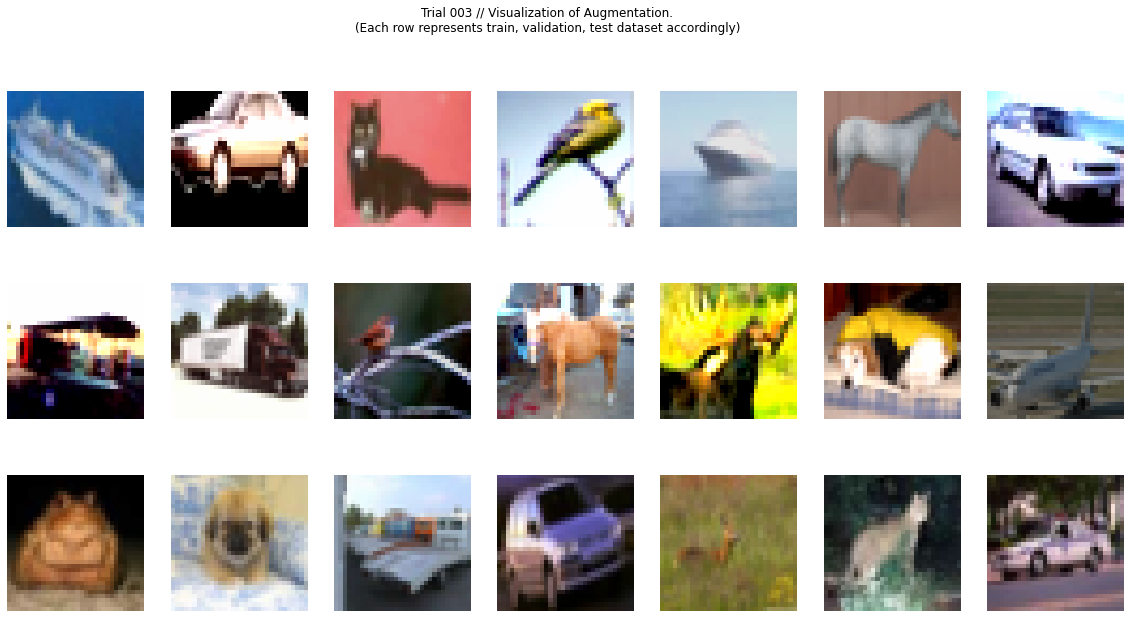

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |

Train: [001] Loss: 2.040, Acc: 23.79% F1(macro): 0.23: 100%|██████████| 156/156 [00:10<00:00, 14.53it/s]
 Val:       Loss: 1.767, Acc: 33.55% F1(macro): 0.32: 100%|██████████| 40/40 [00:01<00:00, 20.99it/s]


Model saved. Current best test f1: 0.316


Train: [002] Loss: 1.691, Acc: 37.56% F1(macro): 0.37: 100%|██████████| 156/156 [00:11<00:00, 14.11it/s]
 Val:       Loss: 1.610, Acc: 40.88% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 20.95it/s]


Model saved. Current best test f1: 0.390


Train: [003] Loss: 1.554, Acc: 43.20% F1(macro): 0.43: 100%|██████████| 156/156 [00:11<00:00, 14.10it/s]
 Val:       Loss: 1.479, Acc: 46.19% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 17.03it/s]


Model saved. Current best test f1: 0.457


Train: [004] Loss: 1.437, Acc: 47.78% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 14.23it/s]
 Val:       Loss: 1.389, Acc: 50.26% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 20.79it/s]


Model saved. Current best test f1: 0.493


Train: [005] Loss: 1.349, Acc: 51.18% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.30it/s]
 Val:       Loss: 1.330, Acc: 51.86% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 20.44it/s]


Model saved. Current best test f1: 0.512


Train: [006] Loss: 1.270, Acc: 54.29% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.42it/s]
 Val:       Loss: 1.262, Acc: 54.61% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 20.15it/s]


Model saved. Current best test f1: 0.538


Train: [007] Loss: 1.194, Acc: 57.15% F1(macro): 0.57: 100%|██████████| 156/156 [00:10<00:00, 14.33it/s]
 Val:       Loss: 1.234, Acc: 56.33% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 20.64it/s]


Model saved. Current best test f1: 0.553


Train: [008] Loss: 1.131, Acc: 59.91% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.33it/s]
 Val:       Loss: 1.188, Acc: 58.16% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 18.23it/s]


Model saved. Current best test f1: 0.579


Train: [009] Loss: 1.074, Acc: 61.94% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 14.35it/s]
 Val:       Loss: 1.150, Acc: 59.36% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Model saved. Current best test f1: 0.586


Train: [010] Loss: 1.014, Acc: 63.96% F1(macro): 0.64: 100%|██████████| 156/156 [00:11<00:00, 13.98it/s]
 Val:       Loss: 1.138, Acc: 60.17% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 21.02it/s]


Model saved. Current best test f1: 0.596
TEST DATASET


 Val:       Loss: 1.068, Acc: 62.42% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 31.61it/s]
[I 2021-11-24 06:38:10,318] Trial 3 finished with value: 0.6202684834036778 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 3 with value: 0.6202684834036778.


Files already downloaded and verified
Files already downloaded and verified


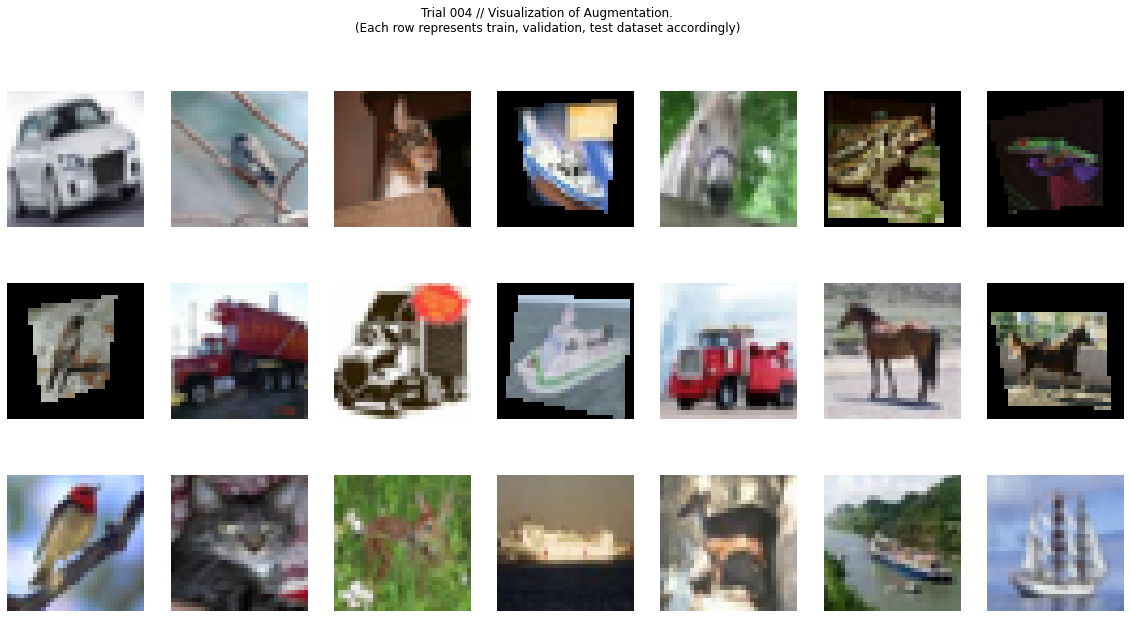

[RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           4

Train: [001] Loss: 2.062, Acc: 22.93% F1(macro): 0.22: 100%|██████████| 156/156 [00:10<00:00, 14.53it/s]
 Val:       Loss: 1.775, Acc: 34.05% F1(macro): 0.32: 100%|██████████| 40/40 [00:01<00:00, 31.49it/s]


Model saved. Current best test f1: 0.322


Train: [002] Loss: 1.686, Acc: 37.35% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.54it/s]
 Val:       Loss: 1.623, Acc: 40.42% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 31.94it/s]


Model saved. Current best test f1: 0.394


Train: [003] Loss: 1.548, Acc: 43.02% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.28it/s]
 Val:       Loss: 1.513, Acc: 44.93% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 31.80it/s]


Model saved. Current best test f1: 0.442


Train: [004] Loss: 1.463, Acc: 46.52% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.32it/s]
 Val:       Loss: 1.441, Acc: 47.71% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 32.53it/s]


Model saved. Current best test f1: 0.474


Train: [005] Loss: 1.409, Acc: 48.62% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.46it/s]
 Val:       Loss: 1.423, Acc: 48.59% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 32.38it/s]


Model saved. Current best test f1: 0.488


Train: [006] Loss: 1.358, Acc: 50.74% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 14.66it/s]
 Val:       Loss: 1.351, Acc: 50.69% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 32.21it/s]


Model saved. Current best test f1: 0.502


Train: [007] Loss: 1.310, Acc: 52.53% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.44it/s]
 Val:       Loss: 1.330, Acc: 51.55% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 31.36it/s]


Model saved. Current best test f1: 0.514


Train: [008] Loss: 1.273, Acc: 54.28% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.71it/s]
 Val:       Loss: 1.296, Acc: 53.51% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 31.74it/s]


Model saved. Current best test f1: 0.531


Train: [009] Loss: 1.250, Acc: 54.99% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.56it/s]
 Val:       Loss: 1.288, Acc: 53.33% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 32.05it/s]


Model saved. Current best test f1: 0.533


Train: [010] Loss: 1.219, Acc: 56.14% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.19it/s]
 Val:       Loss: 1.239, Acc: 56.19% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 29.85it/s]


Model saved. Current best test f1: 0.562
TEST DATASET


 Val:       Loss: 1.107, Acc: 60.13% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 39.80it/s]
[I 2021-11-24 06:40:24,200] Trial 4 finished with value: 0.6005625323617195 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': True}. Best is trial 3 with value: 0.6202684834036778.


Files already downloaded and verified
Files already downloaded and verified


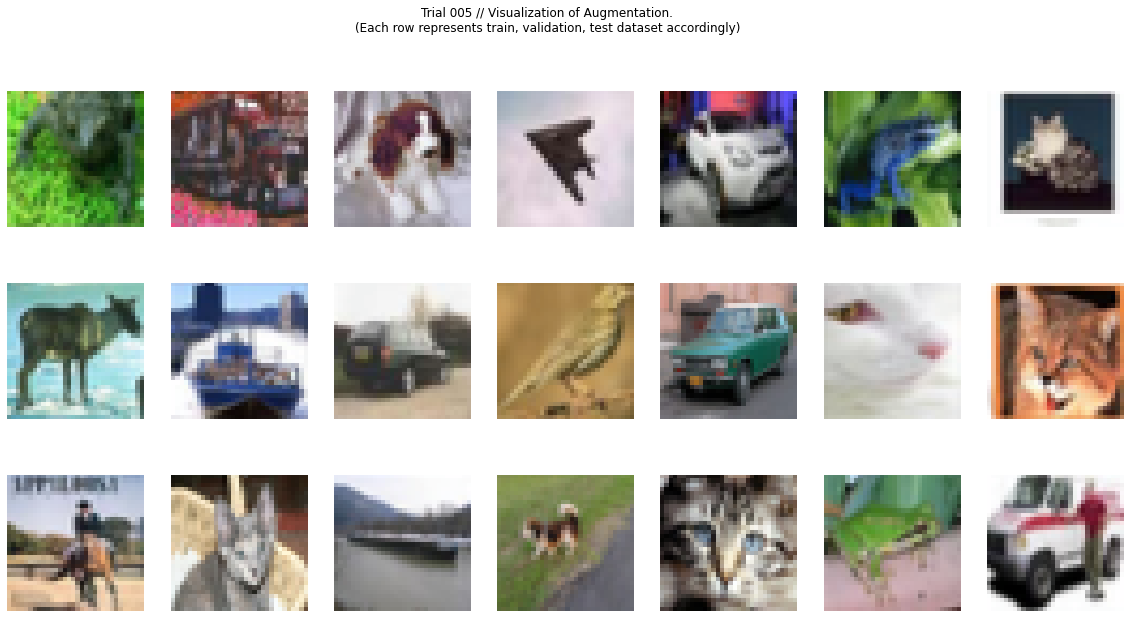

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.924, Acc: 28.53% F1(macro): 0.28: 100%|██████████| 156/156 [00:10<00:00, 14.80it/s]
 Val:       Loss: 1.663, Acc: 40.20% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 39.70it/s]


Model saved. Current best test f1: 0.394


Train: [002] Loss: 1.490, Acc: 45.54% F1(macro): 0.45: 100%|██████████| 156/156 [00:10<00:00, 14.55it/s]
 Val:       Loss: 1.438, Acc: 48.07% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 39.00it/s]


Model saved. Current best test f1: 0.469


Train: [003] Loss: 1.329, Acc: 52.18% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.57it/s]
 Val:       Loss: 1.335, Acc: 51.80% F1(macro): 0.52: 100%|██████████| 40/40 [00:00<00:00, 40.73it/s]


Model saved. Current best test f1: 0.515


Train: [004] Loss: 1.218, Acc: 56.38% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.62it/s]
 Val:       Loss: 1.281, Acc: 54.14% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 37.74it/s]


Model saved. Current best test f1: 0.538


Train: [005] Loss: 1.111, Acc: 60.44% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.55it/s]
 Val:       Loss: 1.256, Acc: 55.87% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 37.81it/s]


Model saved. Current best test f1: 0.556


Train: [006] Loss: 1.043, Acc: 62.92% F1(macro): 0.63: 100%|██████████| 156/156 [00:10<00:00, 14.46it/s]
 Val:       Loss: 1.231, Acc: 56.17% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 38.97it/s]


Model saved. Current best test f1: 0.560


Train: [007] Loss: 0.970, Acc: 65.52% F1(macro): 0.65: 100%|██████████| 156/156 [00:10<00:00, 14.52it/s]
 Val:       Loss: 1.216, Acc: 57.95% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 38.70it/s]


Model saved. Current best test f1: 0.577


Train: [008] Loss: 0.906, Acc: 67.92% F1(macro): 0.68: 100%|██████████| 156/156 [00:10<00:00, 14.87it/s]
 Val:       Loss: 1.252, Acc: 57.42% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 39.16it/s]
Train: [009] Loss: 0.855, Acc: 69.65% F1(macro): 0.70: 100%|██████████| 156/156 [00:10<00:00, 14.31it/s]
 Val:       Loss: 1.186, Acc: 59.40% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 39.64it/s]


Model saved. Current best test f1: 0.590


Train: [010] Loss: 0.802, Acc: 71.63% F1(macro): 0.72: 100%|██████████| 156/156 [00:10<00:00, 14.46it/s]
 Val:       Loss: 1.206, Acc: 59.12% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 37.50it/s]


Model saved. Current best test f1: 0.591
TEST DATASET


 Val:       Loss: 1.186, Acc: 59.68% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 36.75it/s]
[I 2021-11-24 06:42:34,369] Trial 5 finished with value: 0.59720043021475 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 3 with value: 0.6202684834036778.


Files already downloaded and verified
Files already downloaded and verified


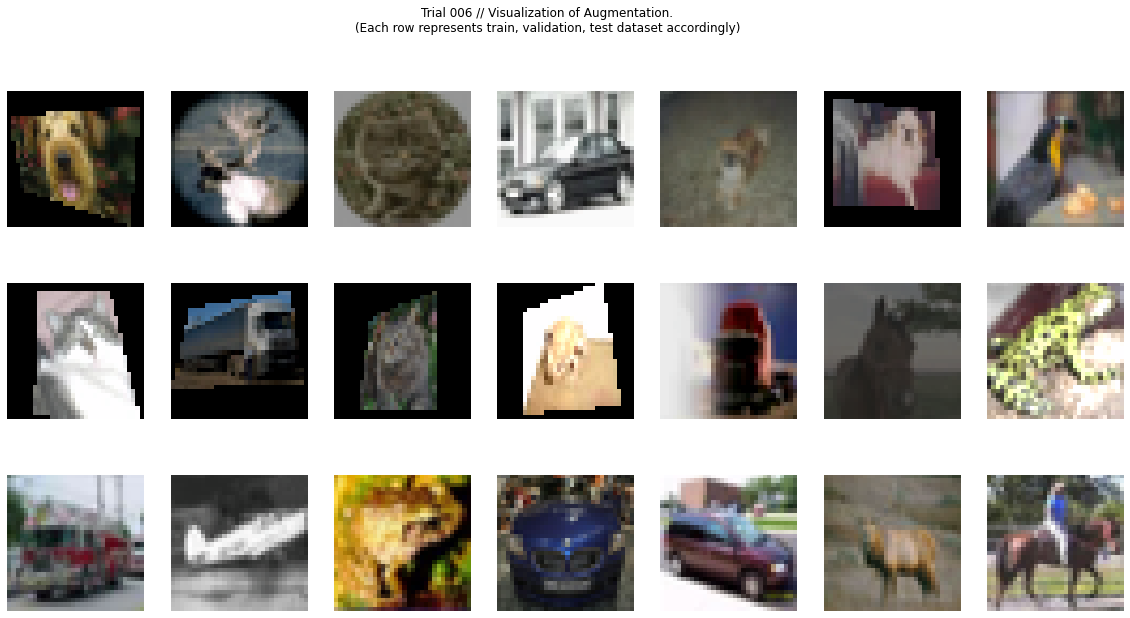

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40    

Train: [001] Loss: 2.213, Acc: 16.89% F1(macro): 0.17: 100%|██████████| 156/156 [00:11<00:00, 13.81it/s]
 Val:       Loss: 2.036, Acc: 24.71% F1(macro): 0.22: 100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


Model saved. Current best test f1: 0.220


Train: [002] Loss: 1.889, Acc: 28.93% F1(macro): 0.28: 100%|██████████| 156/156 [00:11<00:00, 14.02it/s]
 Val:       Loss: 1.803, Acc: 32.63% F1(macro): 0.32: 100%|██████████| 40/40 [00:02<00:00, 15.62it/s]


Model saved. Current best test f1: 0.315


Train: [003] Loss: 1.746, Acc: 35.20% F1(macro): 0.34: 100%|██████████| 156/156 [00:11<00:00, 14.07it/s]
 Val:       Loss: 1.711, Acc: 37.36% F1(macro): 0.36: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s]


Model saved. Current best test f1: 0.360


Train: [004] Loss: 1.669, Acc: 38.42% F1(macro): 0.38: 100%|██████████| 156/156 [00:11<00:00, 14.05it/s]
 Val:       Loss: 1.621, Acc: 41.14% F1(macro): 0.40: 100%|██████████| 40/40 [00:02<00:00, 16.46it/s]


Model saved. Current best test f1: 0.401


Train: [005] Loss: 1.586, Acc: 41.95% F1(macro): 0.41: 100%|██████████| 156/156 [00:11<00:00, 13.94it/s]
 Val:       Loss: 1.576, Acc: 42.78% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


Model saved. Current best test f1: 0.423


Train: [006] Loss: 1.540, Acc: 43.93% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 13.79it/s]
 Val:       Loss: 1.589, Acc: 42.09% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 14.83it/s]
Train: [007] Loss: 1.500, Acc: 45.38% F1(macro): 0.45: 100%|██████████| 156/156 [00:11<00:00, 13.95it/s]
 Val:       Loss: 1.494, Acc: 46.11% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s]


Model saved. Current best test f1: 0.458


Train: [008] Loss: 1.480, Acc: 46.52% F1(macro): 0.46: 100%|██████████| 156/156 [00:11<00:00, 13.86it/s]
 Val:       Loss: 1.504, Acc: 46.22% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s]
Train: [009] Loss: 1.425, Acc: 48.47% F1(macro): 0.48: 100%|██████████| 156/156 [00:11<00:00, 13.75it/s]
 Val:       Loss: 1.423, Acc: 48.85% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 16.93it/s]


Model saved. Current best test f1: 0.480


Train: [010] Loss: 1.370, Acc: 50.56% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 13.98it/s]
 Val:       Loss: 1.376, Acc: 50.78% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 16.32it/s]


Model saved. Current best test f1: 0.505
TEST DATASET


 Val:       Loss: 1.200, Acc: 56.45% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 36.52it/s]
[I 2021-11-24 06:45:03,196] Trial 6 finished with value: 0.5611356559200094 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': True}. Best is trial 3 with value: 0.6202684834036778.


Files already downloaded and verified
Files already downloaded and verified


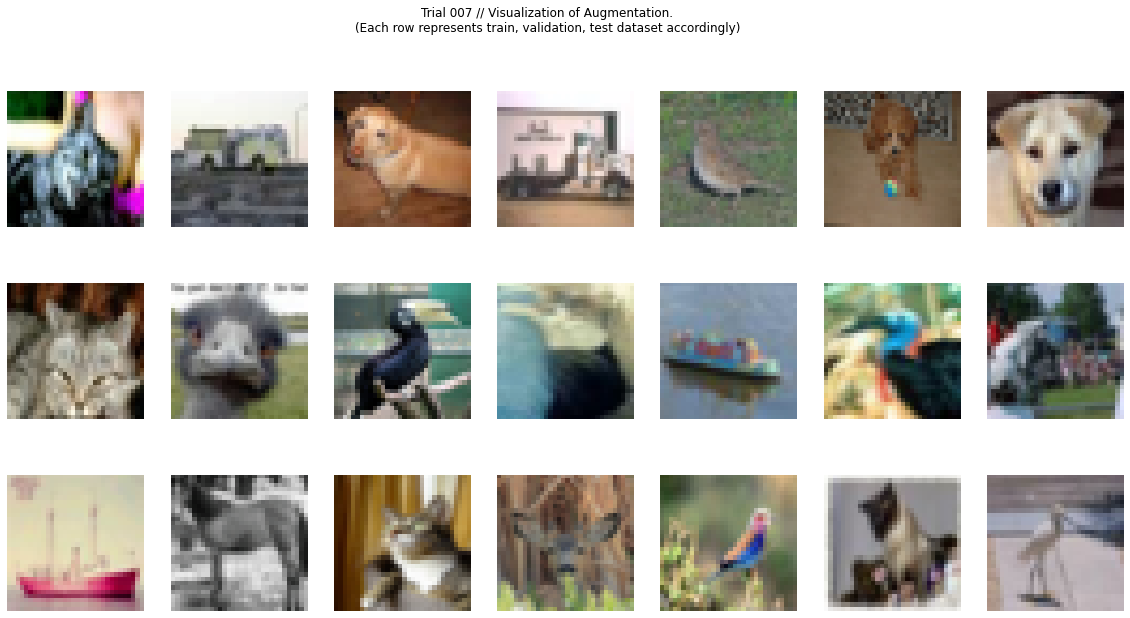

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.943, Acc: 27.48% F1(macro): 0.27: 100%|██████████| 156/156 [00:10<00:00, 14.57it/s]
 Val:       Loss: 1.636, Acc: 39.46% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 38.42it/s]


Model saved. Current best test f1: 0.390


Train: [002] Loss: 1.505, Acc: 44.77% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.73it/s]
 Val:       Loss: 1.494, Acc: 45.36% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 38.91it/s]


Model saved. Current best test f1: 0.443


Train: [003] Loss: 1.350, Acc: 51.06% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.45it/s]
 Val:       Loss: 1.379, Acc: 49.84% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 39.63it/s]


Model saved. Current best test f1: 0.496


Train: [004] Loss: 1.243, Acc: 55.19% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.55it/s]
 Val:       Loss: 1.356, Acc: 51.30% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 38.68it/s]


Model saved. Current best test f1: 0.505


Train: [005] Loss: 1.151, Acc: 58.52% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 14.12it/s]
 Val:       Loss: 1.303, Acc: 52.90% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 39.03it/s]


Model saved. Current best test f1: 0.523


Train: [006] Loss: 1.076, Acc: 61.57% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 14.43it/s]
 Val:       Loss: 1.293, Acc: 54.30% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 38.20it/s]


Model saved. Current best test f1: 0.541


Train: [007] Loss: 1.017, Acc: 63.90% F1(macro): 0.64: 100%|██████████| 156/156 [00:10<00:00, 14.50it/s]
 Val:       Loss: 1.282, Acc: 54.38% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 39.40it/s]
Train: [008] Loss: 0.947, Acc: 66.13% F1(macro): 0.66: 100%|██████████| 156/156 [00:10<00:00, 14.38it/s]
 Val:       Loss: 1.280, Acc: 55.61% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 36.59it/s]


Model saved. Current best test f1: 0.553


Train: [009] Loss: 0.899, Acc: 68.03% F1(macro): 0.68: 100%|██████████| 156/156 [00:10<00:00, 14.36it/s]
 Val:       Loss: 1.266, Acc: 56.42% F1(macro): 0.56: 100%|██████████| 40/40 [00:00<00:00, 41.12it/s]


Model saved. Current best test f1: 0.562


Train: [010] Loss: 0.857, Acc: 69.68% F1(macro): 0.70: 100%|██████████| 156/156 [00:10<00:00, 14.44it/s]
 Val:       Loss: 1.275, Acc: 56.41% F1(macro): 0.56: 100%|██████████| 40/40 [00:00<00:00, 40.02it/s]


Model saved. Current best test f1: 0.563
TEST DATASET


 Val:       Loss: 1.270, Acc: 56.90% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 39.30it/s]
[I 2021-11-24 06:47:14,330] Trial 7 finished with value: 0.5688160810746702 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 3 with value: 0.6202684834036778.


Files already downloaded and verified
Files already downloaded and verified


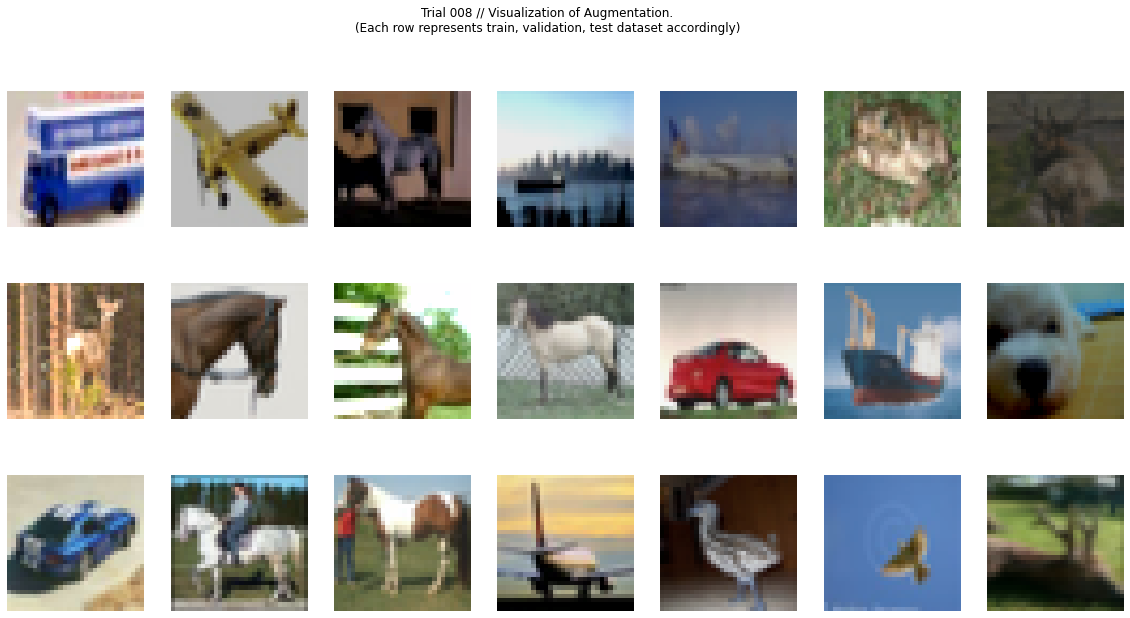

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.040, Acc: 24.50% F1(macro): 0.24: 100%|██████████| 156/156 [00:10<00:00, 14.21it/s]
 Val:       Loss: 1.804, Acc: 33.98% F1(macro): 0.32: 100%|██████████| 40/40 [00:02<00:00, 18.54it/s]


Model saved. Current best test f1: 0.323


Train: [002] Loss: 1.674, Acc: 38.76% F1(macro): 0.38: 100%|██████████| 156/156 [00:11<00:00, 13.49it/s]
 Val:       Loss: 1.661, Acc: 41.80% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s]


Model saved. Current best test f1: 0.414


Train: [003] Loss: 1.536, Acc: 44.10% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 13.81it/s]
 Val:       Loss: 1.489, Acc: 45.17% F1(macro): 0.44: 100%|██████████| 40/40 [00:02<00:00, 16.89it/s]


Model saved. Current best test f1: 0.441


Train: [004] Loss: 1.455, Acc: 47.12% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 14.29it/s]
 Val:       Loss: 1.427, Acc: 48.27% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 17.80it/s]


Model saved. Current best test f1: 0.480


Train: [005] Loss: 1.371, Acc: 50.47% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 14.09it/s]
 Val:       Loss: 1.380, Acc: 49.90% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 18.90it/s]


Model saved. Current best test f1: 0.497


Train: [006] Loss: 1.309, Acc: 53.01% F1(macro): 0.53: 100%|██████████| 156/156 [00:11<00:00, 14.01it/s]
 Val:       Loss: 1.301, Acc: 52.86% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 19.05it/s]


Model saved. Current best test f1: 0.525


Train: [007] Loss: 1.238, Acc: 55.57% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.41it/s]
 Val:       Loss: 1.236, Acc: 55.66% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 18.87it/s]


Model saved. Current best test f1: 0.556


Train: [008] Loss: 1.185, Acc: 57.74% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 13.72it/s]
 Val:       Loss: 1.220, Acc: 55.82% F1(macro): 0.55: 100%|██████████| 40/40 [00:02<00:00, 18.83it/s]
Train: [009] Loss: 1.136, Acc: 59.42% F1(macro): 0.59: 100%|██████████| 156/156 [00:11<00:00, 13.91it/s]
 Val:       Loss: 1.153, Acc: 58.51% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 17.58it/s]


Model saved. Current best test f1: 0.583


Train: [010] Loss: 1.086, Acc: 61.32% F1(macro): 0.61: 100%|██████████| 156/156 [00:11<00:00, 14.18it/s]
 Val:       Loss: 1.110, Acc: 60.46% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 18.81it/s]


Model saved. Current best test f1: 0.601
TEST DATASET


 Val:       Loss: 1.070, Acc: 61.12% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 39.53it/s]
[I 2021-11-24 06:49:40,605] Trial 8 finished with value: 0.6061772313923832 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 3 with value: 0.6202684834036778.


Files already downloaded and verified
Files already downloaded and verified


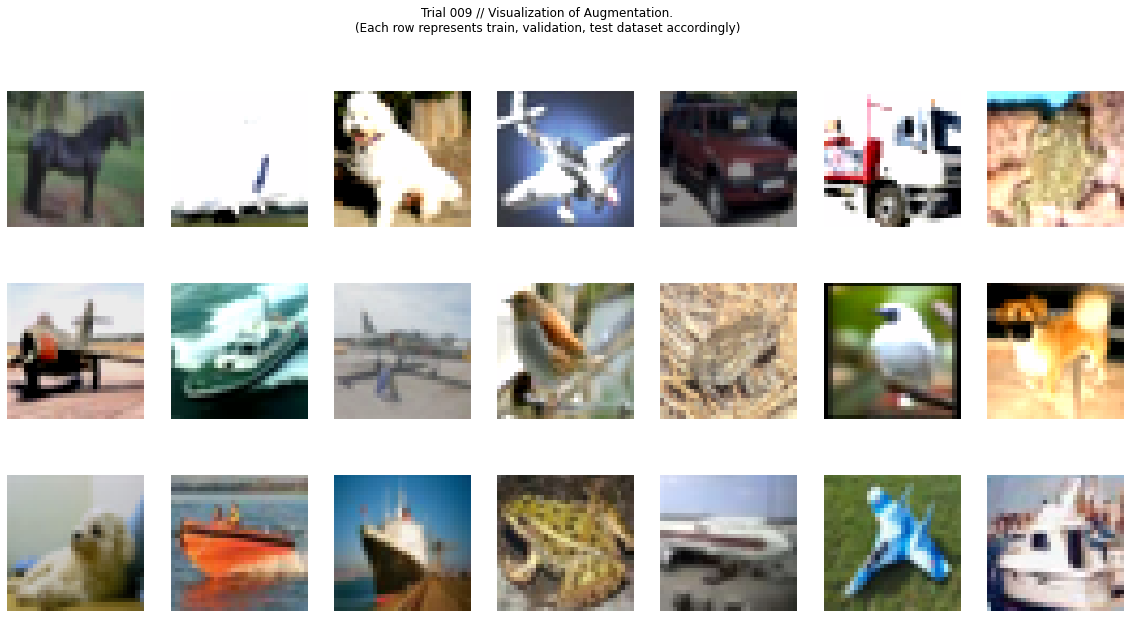

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.059, Acc: 23.34% F1(macro): 0.23: 100%|██████████| 156/156 [00:11<00:00, 13.72it/s]
 Val:       Loss: 1.789, Acc: 33.73% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 18.88it/s]


Model saved. Current best test f1: 0.329


Train: [002] Loss: 1.664, Acc: 38.74% F1(macro): 0.38: 100%|██████████| 156/156 [00:11<00:00, 13.81it/s]
 Val:       Loss: 1.590, Acc: 42.13% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 18.96it/s]


Model saved. Current best test f1: 0.411


Train: [003] Loss: 1.519, Acc: 44.19% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 14.10it/s]
 Val:       Loss: 1.501, Acc: 45.83% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 18.71it/s]


Model saved. Current best test f1: 0.448


Train: [004] Loss: 1.405, Acc: 49.24% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 14.24it/s]
 Val:       Loss: 1.402, Acc: 49.24% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 18.78it/s]


Model saved. Current best test f1: 0.488


Train: [005] Loss: 1.323, Acc: 52.49% F1(macro): 0.52: 100%|██████████| 156/156 [00:11<00:00, 14.03it/s]
 Val:       Loss: 1.332, Acc: 51.68% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.74it/s]


Model saved. Current best test f1: 0.512


Train: [006] Loss: 1.257, Acc: 54.74% F1(macro): 0.55: 100%|██████████| 156/156 [00:11<00:00, 13.94it/s]
 Val:       Loss: 1.250, Acc: 55.13% F1(macro): 0.55: 100%|██████████| 40/40 [00:02<00:00, 18.85it/s]


Model saved. Current best test f1: 0.548


Train: [007] Loss: 1.182, Acc: 57.81% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 14.07it/s]
 Val:       Loss: 1.214, Acc: 56.86% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 19.10it/s]


Model saved. Current best test f1: 0.566


Train: [008] Loss: 1.129, Acc: 59.78% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.23it/s]
 Val:       Loss: 1.178, Acc: 57.98% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Model saved. Current best test f1: 0.574


Train: [009] Loss: 1.069, Acc: 62.00% F1(macro): 0.62: 100%|██████████| 156/156 [00:11<00:00, 14.12it/s]
 Val:       Loss: 1.147, Acc: 58.92% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 19.24it/s]


Model saved. Current best test f1: 0.584


Train: [010] Loss: 1.028, Acc: 63.64% F1(macro): 0.63: 100%|██████████| 156/156 [00:11<00:00, 14.13it/s]
 Val:       Loss: 1.070, Acc: 62.62% F1(macro): 0.62: 100%|██████████| 40/40 [00:02<00:00, 19.01it/s]


Model saved. Current best test f1: 0.625
TEST DATASET


 Val:       Loss: 1.024, Acc: 63.84% F1(macro): 0.64: 100%|██████████| 40/40 [00:01<00:00, 33.79it/s]
[I 2021-11-24 06:52:06,277] Trial 9 finished with value: 0.6352464330075301 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 9 with value: 0.6352464330075301.


Files already downloaded and verified
Files already downloaded and verified


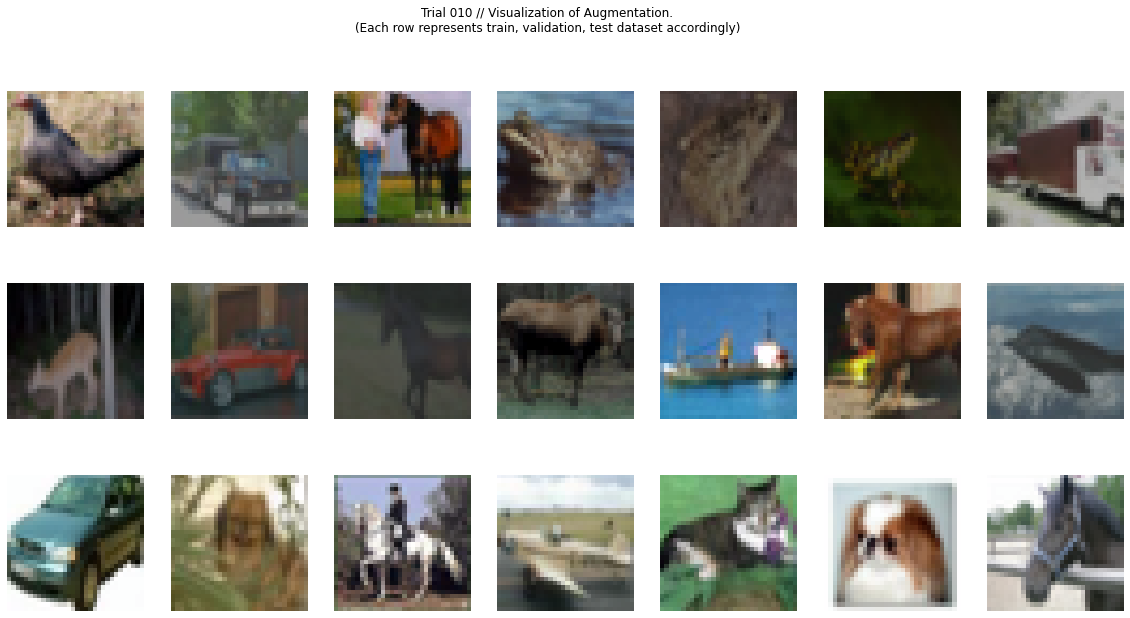

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.072, Acc: 23.08% F1(macro): 0.23: 100%|██████████| 156/156 [00:10<00:00, 14.38it/s]
 Val:       Loss: 1.780, Acc: 34.19% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s]


Model saved. Current best test f1: 0.330


Train: [002] Loss: 1.692, Acc: 38.00% F1(macro): 0.37: 100%|██████████| 156/156 [00:11<00:00, 13.70it/s]
 Val:       Loss: 1.601, Acc: 40.68% F1(macro): 0.39: 100%|██████████| 40/40 [00:02<00:00, 17.69it/s]


Model saved. Current best test f1: 0.393


Train: [003] Loss: 1.542, Acc: 43.74% F1(macro): 0.43: 100%|██████████| 156/156 [00:11<00:00, 13.55it/s]
 Val:       Loss: 1.548, Acc: 44.06% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 18.73it/s]


Model saved. Current best test f1: 0.420


Train: [004] Loss: 1.431, Acc: 47.92% F1(macro): 0.48: 100%|██████████| 156/156 [00:11<00:00, 14.08it/s]
 Val:       Loss: 1.397, Acc: 48.87% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 18.97it/s]


Model saved. Current best test f1: 0.482


Train: [005] Loss: 1.344, Acc: 51.44% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.22it/s]
 Val:       Loss: 1.314, Acc: 52.84% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 18.70it/s]


Model saved. Current best test f1: 0.524


Train: [006] Loss: 1.268, Acc: 54.60% F1(macro): 0.54: 100%|██████████| 156/156 [00:11<00:00, 14.04it/s]
 Val:       Loss: 1.266, Acc: 53.82% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 18.92it/s]


Model saved. Current best test f1: 0.537


Train: [007] Loss: 1.193, Acc: 57.09% F1(macro): 0.57: 100%|██████████| 156/156 [00:11<00:00, 14.12it/s]
 Val:       Loss: 1.189, Acc: 56.97% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 19.16it/s]


Model saved. Current best test f1: 0.563


Train: [008] Loss: 1.135, Acc: 59.40% F1(macro): 0.59: 100%|██████████| 156/156 [00:10<00:00, 14.21it/s]
 Val:       Loss: 1.144, Acc: 58.70% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 18.95it/s]


Model saved. Current best test f1: 0.582


Train: [009] Loss: 1.080, Acc: 61.74% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 14.24it/s]
 Val:       Loss: 1.119, Acc: 59.62% F1(macro): 0.59: 100%|██████████| 40/40 [00:02<00:00, 19.04it/s]


Model saved. Current best test f1: 0.587


Train: [010] Loss: 1.024, Acc: 63.54% F1(macro): 0.63: 100%|██████████| 156/156 [00:11<00:00, 13.85it/s]
 Val:       Loss: 1.106, Acc: 60.52% F1(macro): 0.61: 100%|██████████| 40/40 [00:02<00:00, 19.15it/s]


Model saved. Current best test f1: 0.606
TEST DATASET


 Val:       Loss: 1.062, Acc: 62.60% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 38.75it/s]
[I 2021-11-24 06:54:32,388] Trial 10 finished with value: 0.6271956362986185 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 9 with value: 0.6352464330075301.


Files already downloaded and verified
Files already downloaded and verified


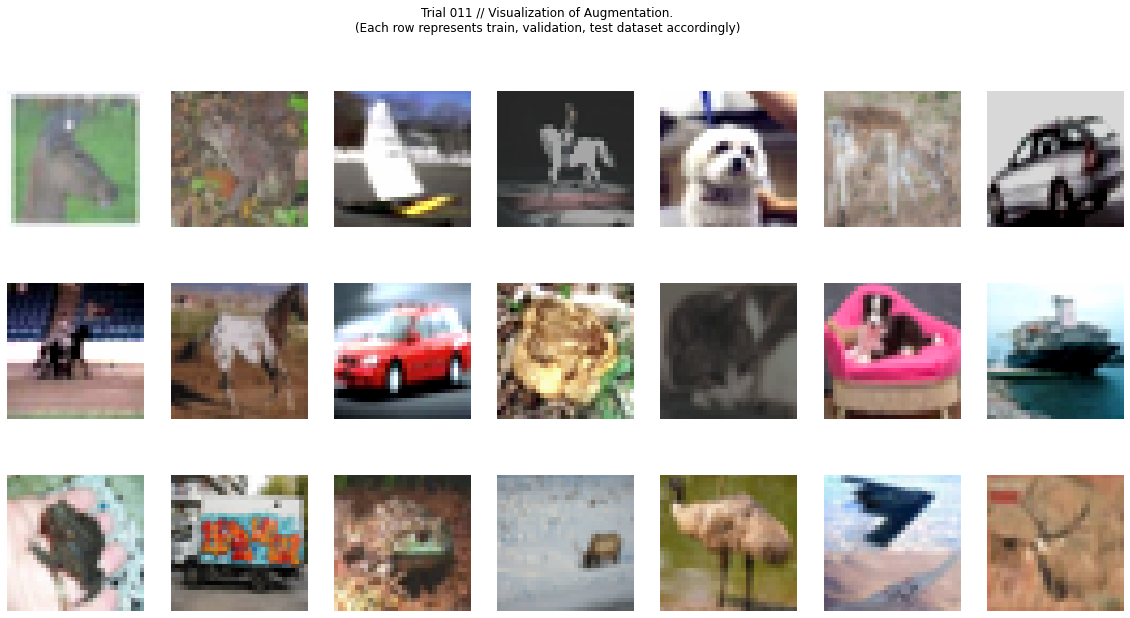

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.049, Acc: 23.24% F1(macro): 0.23: 100%|██████████| 156/156 [00:11<00:00, 14.14it/s]
 Val:       Loss: 1.808, Acc: 34.38% F1(macro): 0.32: 100%|██████████| 40/40 [00:02<00:00, 18.64it/s]


Model saved. Current best test f1: 0.324


Train: [002] Loss: 1.665, Acc: 38.88% F1(macro): 0.38: 100%|██████████| 156/156 [00:10<00:00, 14.50it/s]
 Val:       Loss: 1.664, Acc: 40.23% F1(macro): 0.40: 100%|██████████| 40/40 [00:02<00:00, 18.91it/s]


Model saved. Current best test f1: 0.395


Train: [003] Loss: 1.515, Acc: 44.75% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.32it/s]
 Val:       Loss: 1.476, Acc: 45.64% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 19.12it/s]


Model saved. Current best test f1: 0.453


Train: [004] Loss: 1.417, Acc: 48.77% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.21it/s]
 Val:       Loss: 1.405, Acc: 49.87% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 19.00it/s]


Model saved. Current best test f1: 0.492


Train: [005] Loss: 1.334, Acc: 52.14% F1(macro): 0.52: 100%|██████████| 156/156 [00:11<00:00, 14.13it/s]
 Val:       Loss: 1.367, Acc: 51.78% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 18.19it/s]


Model saved. Current best test f1: 0.516


Train: [006] Loss: 1.250, Acc: 55.69% F1(macro): 0.55: 100%|██████████| 156/156 [00:11<00:00, 14.03it/s]
 Val:       Loss: 1.288, Acc: 54.10% F1(macro): 0.53: 100%|██████████| 40/40 [00:02<00:00, 19.02it/s]


Model saved. Current best test f1: 0.533


Train: [007] Loss: 1.176, Acc: 57.90% F1(macro): 0.58: 100%|██████████| 156/156 [00:10<00:00, 14.39it/s]
 Val:       Loss: 1.186, Acc: 58.09% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 18.63it/s]


Model saved. Current best test f1: 0.583


Train: [008] Loss: 1.112, Acc: 60.59% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.46it/s]
 Val:       Loss: 1.158, Acc: 58.28% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 18.82it/s]


Model saved. Current best test f1: 0.584


Train: [009] Loss: 1.054, Acc: 62.50% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 14.32it/s]
 Val:       Loss: 1.110, Acc: 60.00% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 18.84it/s]


Model saved. Current best test f1: 0.599


Train: [010] Loss: 1.013, Acc: 64.13% F1(macro): 0.64: 100%|██████████| 156/156 [00:10<00:00, 14.27it/s]
 Val:       Loss: 1.080, Acc: 61.59% F1(macro): 0.61: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s]


Model saved. Current best test f1: 0.612
TEST DATASET


 Val:       Loss: 1.034, Acc: 63.68% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 38.51it/s]
[I 2021-11-24 06:56:56,394] Trial 11 finished with value: 0.6308035815140033 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 9 with value: 0.6352464330075301.


Files already downloaded and verified
Files already downloaded and verified


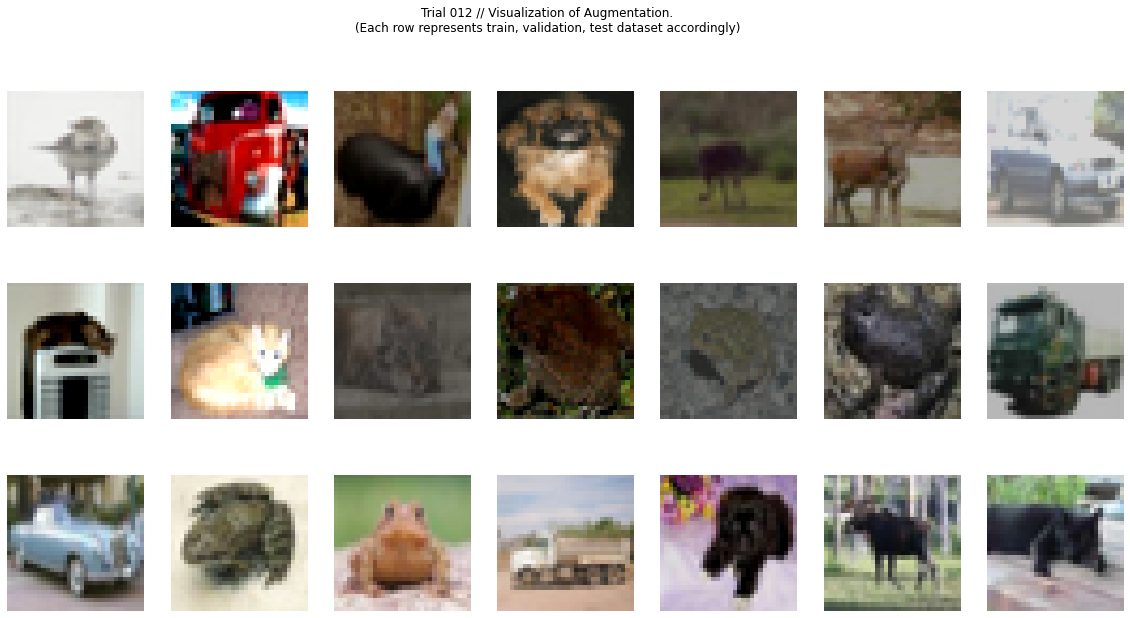

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.058, Acc: 22.85% F1(macro): 0.22: 100%|██████████| 156/156 [00:10<00:00, 14.22it/s]
 Val:       Loss: 1.796, Acc: 33.75% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 18.79it/s]


Model saved. Current best test f1: 0.329


Train: [002] Loss: 1.684, Acc: 37.63% F1(macro): 0.37: 100%|██████████| 156/156 [00:11<00:00, 14.09it/s]
 Val:       Loss: 1.595, Acc: 41.54% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 18.09it/s]


Model saved. Current best test f1: 0.406


Train: [003] Loss: 1.518, Acc: 44.51% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.22it/s]
 Val:       Loss: 1.486, Acc: 46.68% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 19.06it/s]


Model saved. Current best test f1: 0.458


Train: [004] Loss: 1.404, Acc: 49.28% F1(macro): 0.49: 100%|██████████| 156/156 [00:11<00:00, 14.00it/s]
 Val:       Loss: 1.420, Acc: 48.68% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Model saved. Current best test f1: 0.483


Train: [005] Loss: 1.311, Acc: 53.05% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 14.19it/s]
 Val:       Loss: 1.315, Acc: 52.95% F1(macro): 0.53: 100%|██████████| 40/40 [00:02<00:00, 18.96it/s]


Model saved. Current best test f1: 0.528


Train: [006] Loss: 1.238, Acc: 55.75% F1(macro): 0.56: 100%|██████████| 156/156 [00:11<00:00, 14.12it/s]
 Val:       Loss: 1.264, Acc: 54.76% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Model saved. Current best test f1: 0.545


Train: [007] Loss: 1.171, Acc: 58.34% F1(macro): 0.58: 100%|██████████| 156/156 [00:10<00:00, 14.25it/s]
 Val:       Loss: 1.203, Acc: 56.17% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s]


Model saved. Current best test f1: 0.558


Train: [008] Loss: 1.111, Acc: 60.69% F1(macro): 0.61: 100%|██████████| 156/156 [00:11<00:00, 13.67it/s]
 Val:       Loss: 1.137, Acc: 59.25% F1(macro): 0.59: 100%|██████████| 40/40 [00:02<00:00, 18.70it/s]


Model saved. Current best test f1: 0.589


Train: [009] Loss: 1.073, Acc: 62.05% F1(macro): 0.62: 100%|██████████| 156/156 [00:11<00:00, 14.09it/s]
 Val:       Loss: 1.088, Acc: 61.86% F1(macro): 0.62: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s]


Model saved. Current best test f1: 0.617


Train: [010] Loss: 1.008, Acc: 64.23% F1(macro): 0.64: 100%|██████████| 156/156 [00:11<00:00, 14.09it/s]
 Val:       Loss: 1.075, Acc: 61.54% F1(macro): 0.61: 100%|██████████| 40/40 [00:02<00:00, 19.32it/s]

TEST DATASET



 Val:       Loss: 1.001, Acc: 64.61% F1(macro): 0.64: 100%|██████████| 40/40 [00:01<00:00, 37.51it/s]
[I 2021-11-24 06:59:20,999] Trial 12 finished with value: 0.641798902746174 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


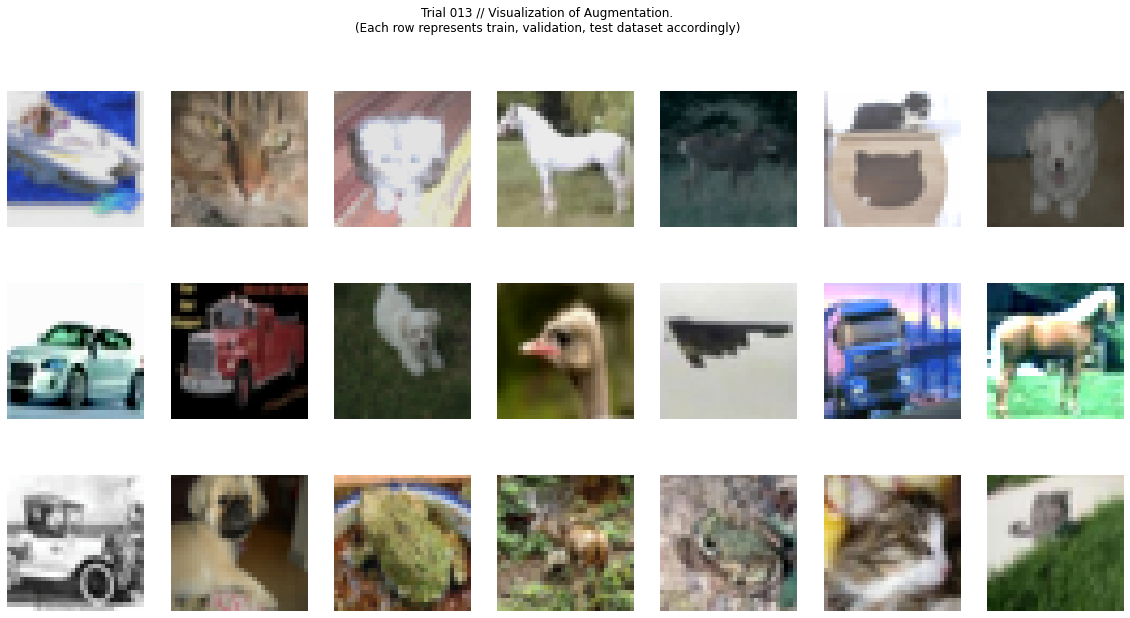

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.016, Acc: 25.04% F1(macro): 0.25: 100%|██████████| 156/156 [00:11<00:00, 13.99it/s]
 Val:       Loss: 1.752, Acc: 36.80% F1(macro): 0.36: 100%|██████████| 40/40 [00:02<00:00, 16.66it/s]


Model saved. Current best test f1: 0.363


Train: [002] Loss: 1.625, Acc: 40.65% F1(macro): 0.40: 100%|██████████| 156/156 [00:11<00:00, 13.88it/s]
 Val:       Loss: 1.567, Acc: 42.56% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 19.16it/s]


Model saved. Current best test f1: 0.414


Train: [003] Loss: 1.491, Acc: 45.68% F1(macro): 0.45: 100%|██████████| 156/156 [00:10<00:00, 14.22it/s]
 Val:       Loss: 1.444, Acc: 47.80% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 19.07it/s]


Model saved. Current best test f1: 0.461


Train: [004] Loss: 1.394, Acc: 49.62% F1(macro): 0.49: 100%|██████████| 156/156 [00:11<00:00, 14.07it/s]
 Val:       Loss: 1.377, Acc: 49.77% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 18.81it/s]


Model saved. Current best test f1: 0.494


Train: [005] Loss: 1.314, Acc: 52.51% F1(macro): 0.52: 100%|██████████| 156/156 [00:11<00:00, 13.80it/s]
 Val:       Loss: 1.325, Acc: 52.10% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s]


Model saved. Current best test f1: 0.509


Train: [006] Loss: 1.257, Acc: 54.80% F1(macro): 0.55: 100%|██████████| 156/156 [00:11<00:00, 13.62it/s]
 Val:       Loss: 1.251, Acc: 54.80% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s]


Model saved. Current best test f1: 0.544


Train: [007] Loss: 1.203, Acc: 56.98% F1(macro): 0.57: 100%|██████████| 156/156 [00:11<00:00, 13.74it/s]
 Val:       Loss: 1.221, Acc: 56.45% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 18.61it/s]


Model saved. Current best test f1: 0.562


Train: [008] Loss: 1.157, Acc: 58.43% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 13.77it/s]
 Val:       Loss: 1.166, Acc: 57.52% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 18.19it/s]


Model saved. Current best test f1: 0.573


Train: [009] Loss: 1.112, Acc: 60.14% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 13.84it/s]
 Val:       Loss: 1.111, Acc: 60.62% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Model saved. Current best test f1: 0.600


Train: [010] Loss: 1.059, Acc: 62.25% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 14.23it/s]
 Val:       Loss: 1.107, Acc: 60.00% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 19.28it/s]


Model saved. Current best test f1: 0.602
TEST DATASET


 Val:       Loss: 1.068, Acc: 61.69% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 39.14it/s]
[I 2021-11-24 07:01:48,212] Trial 13 finished with value: 0.61833418926094 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


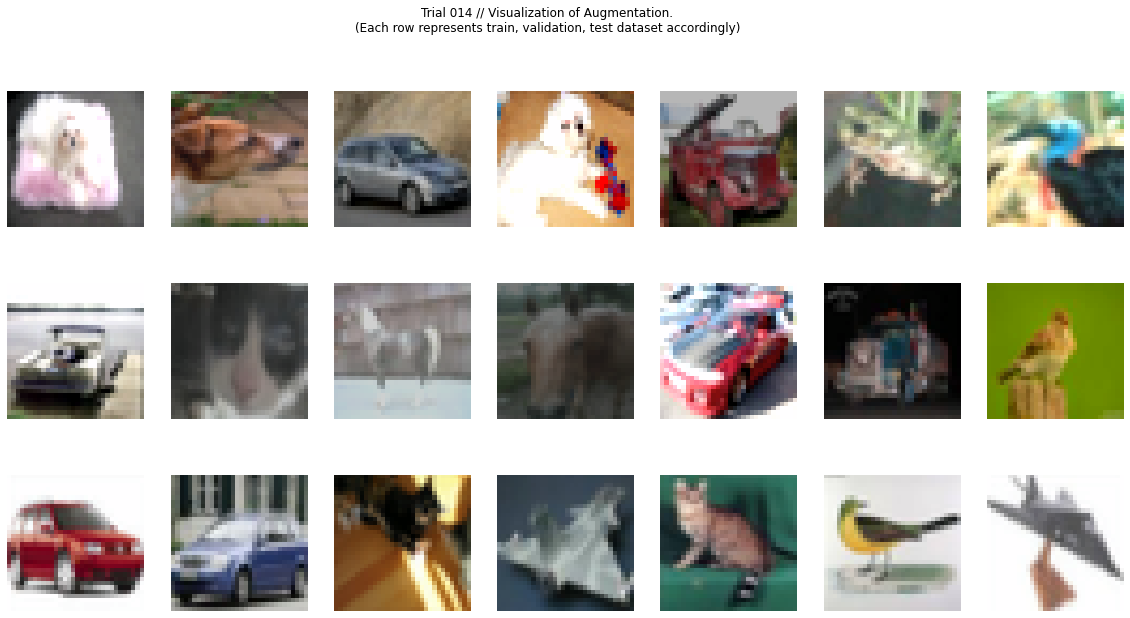

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.026, Acc: 24.63% F1(macro): 0.24: 100%|██████████| 156/156 [00:11<00:00, 13.65it/s]
 Val:       Loss: 1.766, Acc: 34.45% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s]


Model saved. Current best test f1: 0.330


Train: [002] Loss: 1.678, Acc: 38.34% F1(macro): 0.38: 100%|██████████| 156/156 [00:11<00:00, 13.95it/s]
 Val:       Loss: 1.574, Acc: 42.36% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 18.28it/s]


Model saved. Current best test f1: 0.416


Train: [003] Loss: 1.521, Acc: 44.51% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.21it/s]
 Val:       Loss: 1.472, Acc: 46.48% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 19.07it/s]


Model saved. Current best test f1: 0.464


Train: [004] Loss: 1.423, Acc: 48.11% F1(macro): 0.48: 100%|██████████| 156/156 [00:11<00:00, 13.87it/s]
 Val:       Loss: 1.371, Acc: 50.47% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 19.26it/s]


Model saved. Current best test f1: 0.499


Train: [005] Loss: 1.346, Acc: 51.75% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.20it/s]
 Val:       Loss: 1.327, Acc: 52.18% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.89it/s]


Model saved. Current best test f1: 0.515


Train: [006] Loss: 1.270, Acc: 54.62% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.21it/s]
 Val:       Loss: 1.277, Acc: 54.17% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 18.53it/s]


Model saved. Current best test f1: 0.540


Train: [007] Loss: 1.211, Acc: 56.86% F1(macro): 0.57: 100%|██████████| 156/156 [00:10<00:00, 14.30it/s]
 Val:       Loss: 1.270, Acc: 54.77% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s]


Model saved. Current best test f1: 0.542


Train: [008] Loss: 1.150, Acc: 59.10% F1(macro): 0.59: 100%|██████████| 156/156 [00:11<00:00, 14.11it/s]
 Val:       Loss: 1.136, Acc: 60.20% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


Model saved. Current best test f1: 0.600


Train: [009] Loss: 1.102, Acc: 60.89% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 14.40it/s]
 Val:       Loss: 1.154, Acc: 59.52% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 17.85it/s]
Train: [010] Loss: 1.076, Acc: 61.73% F1(macro): 0.62: 100%|██████████| 156/156 [00:11<00:00, 14.03it/s]
 Val:       Loss: 1.105, Acc: 61.78% F1(macro): 0.62: 100%|██████████| 40/40 [00:02<00:00, 19.16it/s]


Model saved. Current best test f1: 0.615
TEST DATASET


 Val:       Loss: 1.038, Acc: 62.67% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 36.53it/s]
[I 2021-11-24 07:04:13,278] Trial 14 finished with value: 0.6234630872065582 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


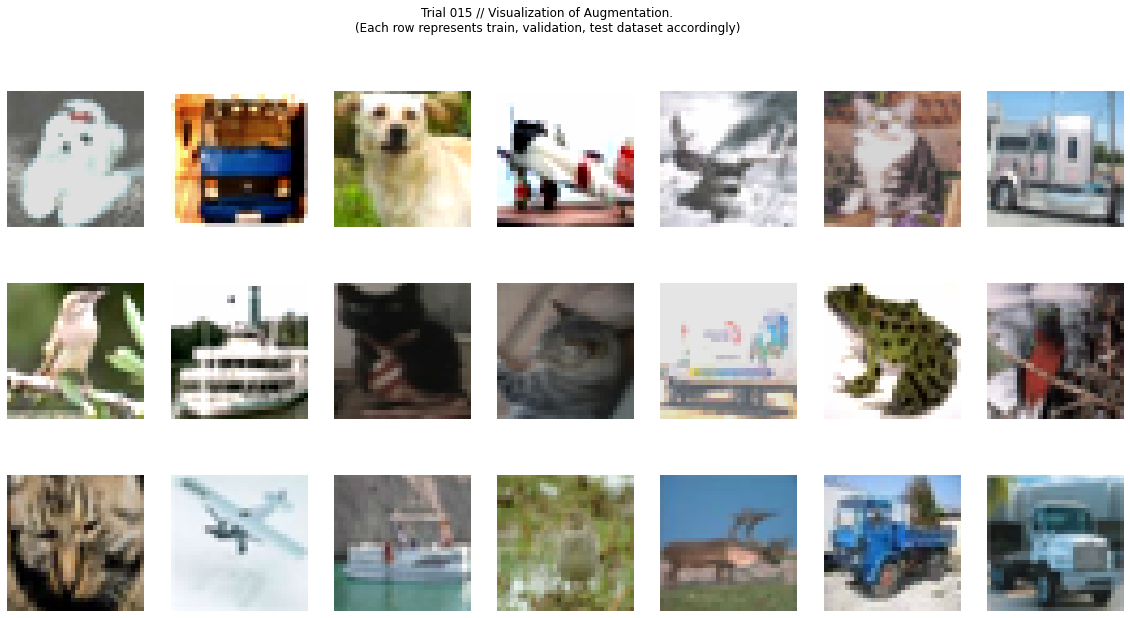

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.040, Acc: 24.34% F1(macro): 0.24: 100%|██████████| 156/156 [00:11<00:00, 14.16it/s]
 Val:       Loss: 1.808, Acc: 33.96% F1(macro): 0.32: 100%|██████████| 40/40 [00:02<00:00, 18.29it/s]


Model saved. Current best test f1: 0.322


Train: [002] Loss: 1.638, Acc: 39.83% F1(macro): 0.39: 100%|██████████| 156/156 [00:11<00:00, 13.57it/s]
 Val:       Loss: 1.566, Acc: 42.12% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 18.00it/s]


Model saved. Current best test f1: 0.420


Train: [003] Loss: 1.502, Acc: 44.90% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 14.00it/s]
 Val:       Loss: 1.471, Acc: 46.22% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 19.16it/s]


Model saved. Current best test f1: 0.456


Train: [004] Loss: 1.437, Acc: 47.56% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 14.18it/s]
 Val:       Loss: 1.397, Acc: 49.65% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 19.00it/s]


Model saved. Current best test f1: 0.495


Train: [005] Loss: 1.359, Acc: 51.04% F1(macro): 0.51: 100%|██████████| 156/156 [00:11<00:00, 14.07it/s]
 Val:       Loss: 1.387, Acc: 50.33% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.64it/s]


Model saved. Current best test f1: 0.506


Train: [006] Loss: 1.294, Acc: 53.63% F1(macro): 0.53: 100%|██████████| 156/156 [00:11<00:00, 14.13it/s]
 Val:       Loss: 1.311, Acc: 53.55% F1(macro): 0.53: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Model saved. Current best test f1: 0.531


Train: [007] Loss: 1.247, Acc: 55.36% F1(macro): 0.55: 100%|██████████| 156/156 [00:11<00:00, 13.61it/s]
 Val:       Loss: 1.261, Acc: 54.46% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 18.13it/s]


Model saved. Current best test f1: 0.542


Train: [008] Loss: 1.202, Acc: 57.11% F1(macro): 0.57: 100%|██████████| 156/156 [00:11<00:00, 13.82it/s]
 Val:       Loss: 1.223, Acc: 56.44% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 18.92it/s]


Model saved. Current best test f1: 0.563


Train: [009] Loss: 1.141, Acc: 59.48% F1(macro): 0.59: 100%|██████████| 156/156 [00:11<00:00, 14.03it/s]
 Val:       Loss: 1.225, Acc: 57.28% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 18.73it/s]


Model saved. Current best test f1: 0.575


Train: [010] Loss: 1.096, Acc: 61.10% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 14.27it/s]
 Val:       Loss: 1.124, Acc: 59.31% F1(macro): 0.59: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Model saved. Current best test f1: 0.590
TEST DATASET


 Val:       Loss: 1.073, Acc: 61.10% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 32.37it/s]
[I 2021-11-24 07:06:40,131] Trial 15 finished with value: 0.6060923335010906 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


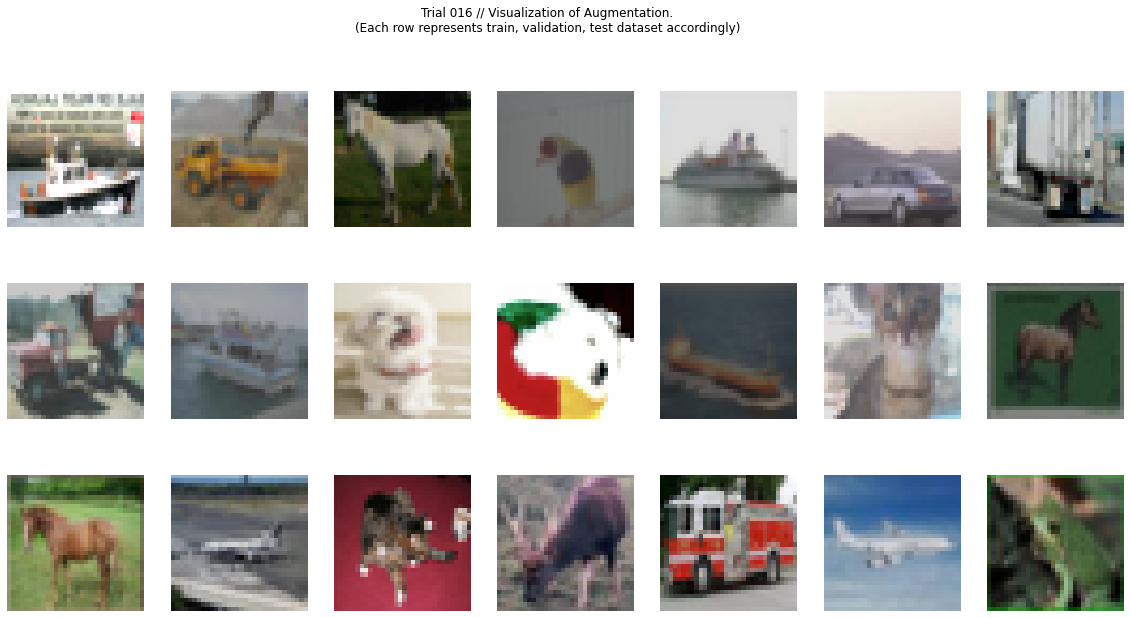

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.087, Acc: 22.23% F1(macro): 0.22: 100%|██████████| 156/156 [00:11<00:00, 13.66it/s]
 Val:       Loss: 1.809, Acc: 32.26% F1(macro): 0.31: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s]


Model saved. Current best test f1: 0.314


Train: [002] Loss: 1.702, Acc: 37.48% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.38it/s]
 Val:       Loss: 1.617, Acc: 41.29% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 18.83it/s]


Model saved. Current best test f1: 0.414


Train: [003] Loss: 1.551, Acc: 43.51% F1(macro): 0.43: 100%|██████████| 156/156 [00:11<00:00, 14.11it/s]
 Val:       Loss: 1.530, Acc: 44.17% F1(macro): 0.43: 100%|██████████| 40/40 [00:02<00:00, 19.03it/s]


Model saved. Current best test f1: 0.431


Train: [004] Loss: 1.456, Acc: 47.22% F1(macro): 0.47: 100%|██████████| 156/156 [00:11<00:00, 14.08it/s]
 Val:       Loss: 1.431, Acc: 48.12% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 18.89it/s]


Model saved. Current best test f1: 0.475


Train: [005] Loss: 1.376, Acc: 50.08% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 13.68it/s]
 Val:       Loss: 1.389, Acc: 49.95% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 19.03it/s]


Model saved. Current best test f1: 0.495


Train: [006] Loss: 1.312, Acc: 52.54% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.30it/s]
 Val:       Loss: 1.345, Acc: 51.76% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s]


Model saved. Current best test f1: 0.514


Train: [007] Loss: 1.248, Acc: 55.26% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.42it/s]
 Val:       Loss: 1.268, Acc: 54.72% F1(macro): 0.55: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Model saved. Current best test f1: 0.546


Train: [008] Loss: 1.192, Acc: 57.51% F1(macro): 0.57: 100%|██████████| 156/156 [00:10<00:00, 14.21it/s]
 Val:       Loss: 1.249, Acc: 55.83% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 18.76it/s]


Model saved. Current best test f1: 0.557


Train: [009] Loss: 1.132, Acc: 59.80% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.23it/s]
 Val:       Loss: 1.190, Acc: 57.56% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s]


Model saved. Current best test f1: 0.572


Train: [010] Loss: 1.090, Acc: 61.12% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 14.25it/s]
 Val:       Loss: 1.191, Acc: 58.68% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s]


Model saved. Current best test f1: 0.580
TEST DATASET


 Val:       Loss: 1.099, Acc: 60.92% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 35.95it/s]
[I 2021-11-24 07:09:06,159] Trial 16 finished with value: 0.5997461978127142 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


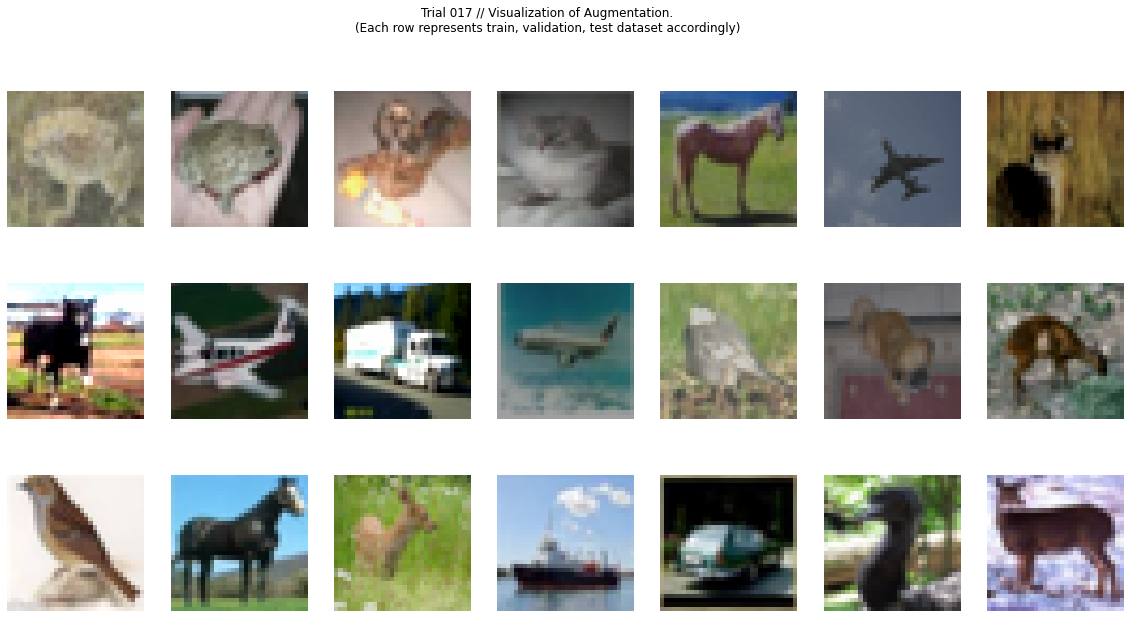

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.083, Acc: 22.73% F1(macro): 0.22: 100%|██████████| 156/156 [00:11<00:00, 13.83it/s]
 Val:       Loss: 1.918, Acc: 31.80% F1(macro): 0.30: 100%|██████████| 40/40 [00:02<00:00, 18.72it/s]


Model saved. Current best test f1: 0.300


Train: [002] Loss: 1.719, Acc: 36.61% F1(macro): 0.36: 100%|██████████| 156/156 [00:10<00:00, 14.28it/s]
 Val:       Loss: 1.616, Acc: 40.39% F1(macro): 0.40: 100%|██████████| 40/40 [00:02<00:00, 18.34it/s]


Model saved. Current best test f1: 0.405


Train: [003] Loss: 1.561, Acc: 42.85% F1(macro): 0.42: 100%|██████████| 156/156 [00:10<00:00, 14.31it/s]
 Val:       Loss: 1.505, Acc: 44.76% F1(macro): 0.44: 100%|██████████| 40/40 [00:02<00:00, 19.10it/s]


Model saved. Current best test f1: 0.438


Train: [004] Loss: 1.465, Acc: 46.70% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.28it/s]
 Val:       Loss: 1.431, Acc: 48.42% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 18.40it/s]


Model saved. Current best test f1: 0.476


Train: [005] Loss: 1.384, Acc: 49.77% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 14.33it/s]
 Val:       Loss: 1.381, Acc: 49.47% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 18.75it/s]


Model saved. Current best test f1: 0.490


Train: [006] Loss: 1.330, Acc: 52.02% F1(macro): 0.52: 100%|██████████| 156/156 [00:11<00:00, 14.18it/s]
 Val:       Loss: 1.316, Acc: 52.21% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 18.30it/s]


Model saved. Current best test f1: 0.521


Train: [007] Loss: 1.263, Acc: 54.61% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.48it/s]
 Val:       Loss: 1.279, Acc: 53.49% F1(macro): 0.53: 100%|██████████| 40/40 [00:02<00:00, 18.74it/s]


Model saved. Current best test f1: 0.535


Train: [008] Loss: 1.207, Acc: 56.66% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.39it/s]
 Val:       Loss: 1.244, Acc: 55.87% F1(macro): 0.55: 100%|██████████| 40/40 [00:02<00:00, 18.76it/s]


Model saved. Current best test f1: 0.554


Train: [009] Loss: 1.155, Acc: 58.52% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 14.05it/s]
 Val:       Loss: 1.207, Acc: 57.06% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 19.03it/s]


Model saved. Current best test f1: 0.565


Train: [010] Loss: 1.106, Acc: 60.68% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 14.00it/s]
 Val:       Loss: 1.173, Acc: 58.13% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 18.94it/s]


Model saved. Current best test f1: 0.578
TEST DATASET


 Val:       Loss: 1.103, Acc: 60.52% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 39.98it/s]
[I 2021-11-24 07:11:31,033] Trial 17 finished with value: 0.6018519219628695 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


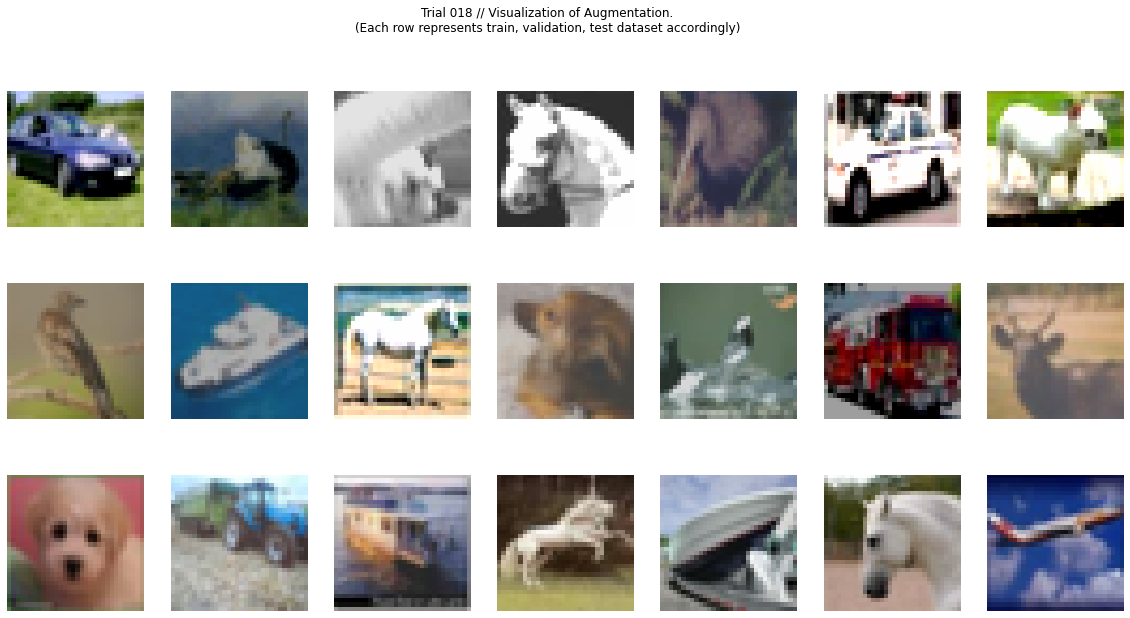

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.043, Acc: 24.08% F1(macro): 0.23: 100%|██████████| 156/156 [00:11<00:00, 13.88it/s]
 Val:       Loss: 1.808, Acc: 34.76% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 18.50it/s]


Model saved. Current best test f1: 0.329


Train: [002] Loss: 1.666, Acc: 39.01% F1(macro): 0.38: 100%|██████████| 156/156 [00:10<00:00, 14.19it/s]
 Val:       Loss: 1.600, Acc: 42.29% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 18.71it/s]


Model saved. Current best test f1: 0.412


Train: [003] Loss: 1.535, Acc: 43.86% F1(macro): 0.43: 100%|██████████| 156/156 [00:11<00:00, 13.72it/s]
 Val:       Loss: 1.563, Acc: 44.58% F1(macro): 0.44: 100%|██████████| 40/40 [00:02<00:00, 19.09it/s]


Model saved. Current best test f1: 0.442


Train: [004] Loss: 1.437, Acc: 47.82% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 14.25it/s]
 Val:       Loss: 1.449, Acc: 48.30% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s]


Model saved. Current best test f1: 0.481


Train: [005] Loss: 1.352, Acc: 51.20% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.39it/s]
 Val:       Loss: 1.380, Acc: 52.32% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 18.88it/s]


Model saved. Current best test f1: 0.519


Train: [006] Loss: 1.282, Acc: 53.73% F1(macro): 0.53: 100%|██████████| 156/156 [00:11<00:00, 14.17it/s]
 Val:       Loss: 1.303, Acc: 53.37% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 18.28it/s]


Model saved. Current best test f1: 0.537


Train: [007] Loss: 1.213, Acc: 56.54% F1(macro): 0.56: 100%|██████████| 156/156 [00:11<00:00, 13.99it/s]
 Val:       Loss: 1.285, Acc: 53.79% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 19.33it/s]
Train: [008] Loss: 1.153, Acc: 59.12% F1(macro): 0.59: 100%|██████████| 156/156 [00:10<00:00, 14.31it/s]
 Val:       Loss: 1.194, Acc: 57.43% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 17.06it/s]


Model saved. Current best test f1: 0.572


Train: [009] Loss: 1.108, Acc: 60.67% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 13.64it/s]
 Val:       Loss: 1.141, Acc: 59.20% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 18.36it/s]


Model saved. Current best test f1: 0.584


Train: [010] Loss: 1.068, Acc: 62.16% F1(macro): 0.62: 100%|██████████| 156/156 [00:11<00:00, 13.94it/s]
 Val:       Loss: 1.133, Acc: 59.89% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 18.92it/s]


Model saved. Current best test f1: 0.597
TEST DATASET


 Val:       Loss: 1.069, Acc: 61.63% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 38.36it/s]
[I 2021-11-24 07:13:56,700] Trial 18 finished with value: 0.6118442244023196 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


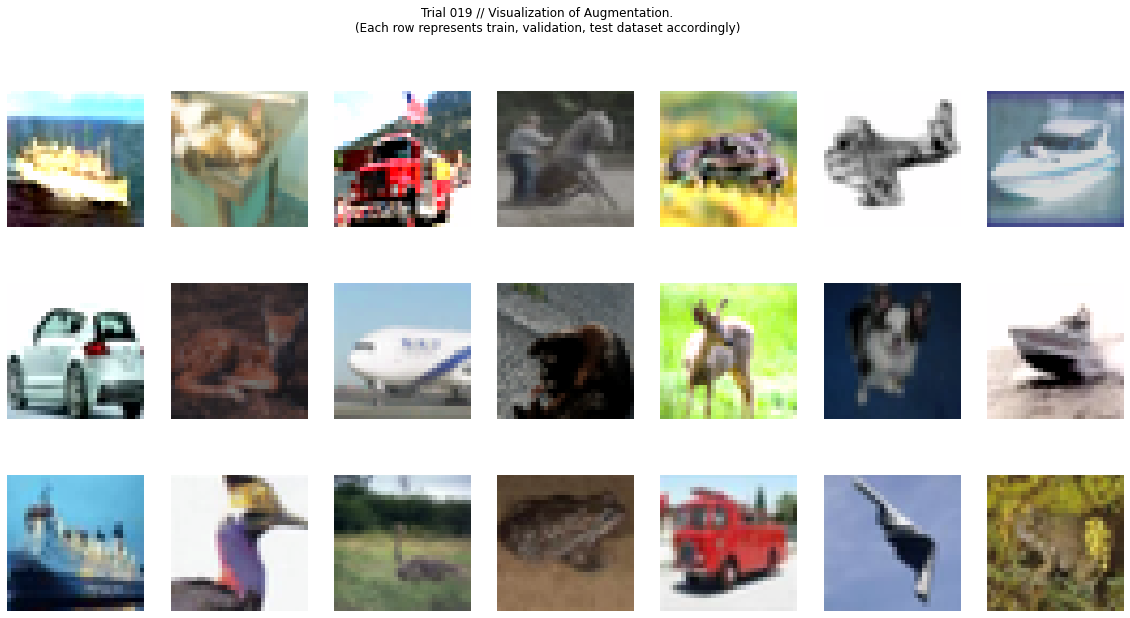

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.093, Acc: 22.01% F1(macro): 0.22: 100%|██████████| 156/156 [00:11<00:00, 13.79it/s]
 Val:       Loss: 1.915, Acc: 30.67% F1(macro): 0.30: 100%|██████████| 40/40 [00:02<00:00, 18.90it/s]


Model saved. Current best test f1: 0.297


Train: [002] Loss: 1.714, Acc: 36.88% F1(macro): 0.36: 100%|██████████| 156/156 [00:11<00:00, 13.98it/s]
 Val:       Loss: 1.673, Acc: 39.29% F1(macro): 0.39: 100%|██████████| 40/40 [00:02<00:00, 19.32it/s]


Model saved. Current best test f1: 0.386


Train: [003] Loss: 1.561, Acc: 43.26% F1(macro): 0.43: 100%|██████████| 156/156 [00:11<00:00, 13.96it/s]
 Val:       Loss: 1.533, Acc: 43.80% F1(macro): 0.43: 100%|██████████| 40/40 [00:02<00:00, 19.01it/s]


Model saved. Current best test f1: 0.434


Train: [004] Loss: 1.462, Acc: 47.13% F1(macro): 0.47: 100%|██████████| 156/156 [00:11<00:00, 13.82it/s]
 Val:       Loss: 1.480, Acc: 46.14% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s]


Model saved. Current best test f1: 0.461


Train: [005] Loss: 1.383, Acc: 50.23% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 13.93it/s]
 Val:       Loss: 1.399, Acc: 49.34% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 19.12it/s]


Model saved. Current best test f1: 0.491


Train: [006] Loss: 1.321, Acc: 52.70% F1(macro): 0.52: 100%|██████████| 156/156 [00:11<00:00, 13.65it/s]
 Val:       Loss: 1.346, Acc: 51.61% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s]


Model saved. Current best test f1: 0.519


Train: [007] Loss: 1.266, Acc: 54.61% F1(macro): 0.54: 100%|██████████| 156/156 [00:11<00:00, 14.14it/s]
 Val:       Loss: 1.322, Acc: 52.61% F1(macro): 0.53: 100%|██████████| 40/40 [00:02<00:00, 18.97it/s]


Model saved. Current best test f1: 0.526


Train: [008] Loss: 1.220, Acc: 56.28% F1(macro): 0.56: 100%|██████████| 156/156 [00:11<00:00, 13.68it/s]
 Val:       Loss: 1.289, Acc: 53.45% F1(macro): 0.53: 100%|██████████| 40/40 [00:02<00:00, 19.32it/s]


Model saved. Current best test f1: 0.528


Train: [009] Loss: 1.174, Acc: 57.80% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 13.72it/s]
 Val:       Loss: 1.238, Acc: 56.33% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 18.45it/s]


Model saved. Current best test f1: 0.559


Train: [010] Loss: 1.119, Acc: 59.92% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 14.06it/s]
 Val:       Loss: 1.194, Acc: 57.32% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s]


Model saved. Current best test f1: 0.572
TEST DATASET


 Val:       Loss: 1.125, Acc: 60.07% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 35.52it/s]
[I 2021-11-24 07:16:24,136] Trial 19 finished with value: 0.5978658404203546 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


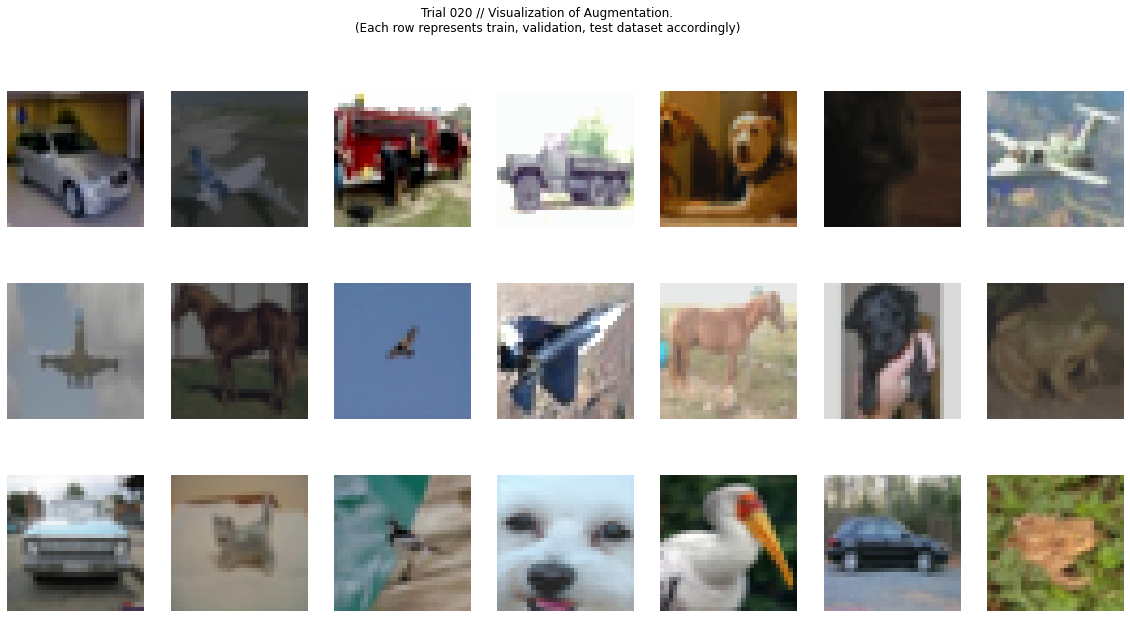

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.060, Acc: 23.33% F1(macro): 0.23: 100%|██████████| 156/156 [00:10<00:00, 14.29it/s]
 Val:       Loss: 1.896, Acc: 31.39% F1(macro): 0.30: 100%|██████████| 40/40 [00:02<00:00, 18.81it/s]


Model saved. Current best test f1: 0.295


Train: [002] Loss: 1.682, Acc: 38.38% F1(macro): 0.38: 100%|██████████| 156/156 [00:11<00:00, 14.02it/s]
 Val:       Loss: 1.641, Acc: 41.39% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 18.95it/s]


Model saved. Current best test f1: 0.407


Train: [003] Loss: 1.537, Acc: 43.83% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.35it/s]
 Val:       Loss: 1.526, Acc: 44.49% F1(macro): 0.43: 100%|██████████| 40/40 [00:02<00:00, 18.59it/s]


Model saved. Current best test f1: 0.430


Train: [004] Loss: 1.433, Acc: 48.12% F1(macro): 0.48: 100%|██████████| 156/156 [00:11<00:00, 14.18it/s]
 Val:       Loss: 1.408, Acc: 48.27% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 19.20it/s]


Model saved. Current best test f1: 0.474


Train: [005] Loss: 1.337, Acc: 51.73% F1(macro): 0.51: 100%|██████████| 156/156 [00:11<00:00, 14.15it/s]
 Val:       Loss: 1.351, Acc: 51.73% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.99it/s]


Model saved. Current best test f1: 0.515


Train: [006] Loss: 1.266, Acc: 54.40% F1(macro): 0.54: 100%|██████████| 156/156 [00:11<00:00, 13.97it/s]
 Val:       Loss: 1.275, Acc: 54.11% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 19.32it/s]


Model saved. Current best test f1: 0.539


Train: [007] Loss: 1.185, Acc: 57.29% F1(macro): 0.57: 100%|██████████| 156/156 [00:11<00:00, 14.06it/s]
 Val:       Loss: 1.231, Acc: 56.40% F1(macro): 0.55: 100%|██████████| 40/40 [00:02<00:00, 18.73it/s]


Model saved. Current best test f1: 0.555


Train: [008] Loss: 1.137, Acc: 59.27% F1(macro): 0.59: 100%|██████████| 156/156 [00:11<00:00, 14.09it/s]
 Val:       Loss: 1.206, Acc: 57.49% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 17.35it/s]


Model saved. Current best test f1: 0.573


Train: [009] Loss: 1.109, Acc: 60.62% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 14.17it/s]
 Val:       Loss: 1.206, Acc: 57.67% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 18.78it/s]
Train: [010] Loss: 1.065, Acc: 62.36% F1(macro): 0.62: 100%|██████████| 156/156 [00:11<00:00, 13.88it/s]
 Val:       Loss: 1.150, Acc: 59.97% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 18.76it/s]


Model saved. Current best test f1: 0.604
TEST DATASET


 Val:       Loss: 1.064, Acc: 61.86% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 37.22it/s]
[I 2021-11-24 07:18:48,952] Trial 20 finished with value: 0.6180775256512683 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


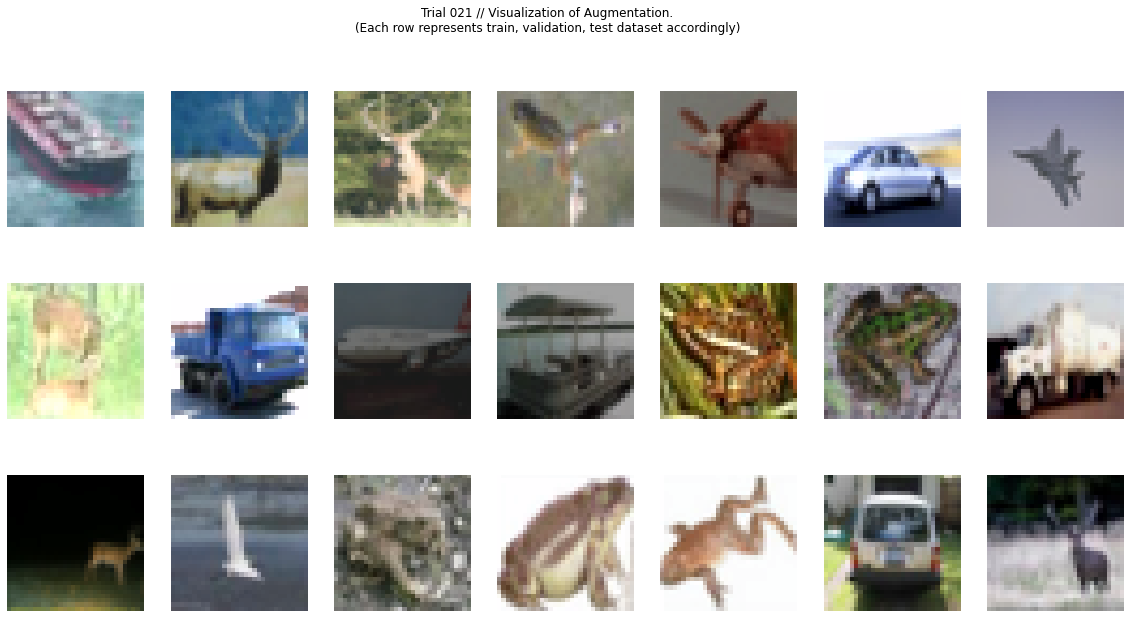

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.054, Acc: 23.35% F1(macro): 0.23: 100%|██████████| 156/156 [00:11<00:00, 13.77it/s]
 Val:       Loss: 1.808, Acc: 33.85% F1(macro): 0.31: 100%|██████████| 40/40 [00:02<00:00, 18.69it/s]


Model saved. Current best test f1: 0.310


Train: [002] Loss: 1.688, Acc: 38.60% F1(macro): 0.38: 100%|██████████| 156/156 [00:11<00:00, 13.84it/s]
 Val:       Loss: 1.616, Acc: 40.21% F1(macro): 0.38: 100%|██████████| 40/40 [00:02<00:00, 18.68it/s]


Model saved. Current best test f1: 0.385


Train: [003] Loss: 1.538, Acc: 44.01% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 13.99it/s]
 Val:       Loss: 1.477, Acc: 46.64% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s]


Model saved. Current best test f1: 0.460


Train: [004] Loss: 1.432, Acc: 48.56% F1(macro): 0.48: 100%|██████████| 156/156 [00:11<00:00, 13.83it/s]
 Val:       Loss: 1.393, Acc: 49.89% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 19.32it/s]


Model saved. Current best test f1: 0.492


Train: [005] Loss: 1.341, Acc: 51.72% F1(macro): 0.51: 100%|██████████| 156/156 [00:11<00:00, 14.02it/s]
 Val:       Loss: 1.319, Acc: 52.88% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 18.66it/s]


Model saved. Current best test f1: 0.522


Train: [006] Loss: 1.264, Acc: 54.84% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.23it/s]
 Val:       Loss: 1.260, Acc: 54.91% F1(macro): 0.55: 100%|██████████| 40/40 [00:02<00:00, 18.92it/s]


Model saved. Current best test f1: 0.551


Train: [007] Loss: 1.201, Acc: 57.26% F1(macro): 0.57: 100%|██████████| 156/156 [00:11<00:00, 13.83it/s]
 Val:       Loss: 1.221, Acc: 56.15% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s]


Model saved. Current best test f1: 0.558


Train: [008] Loss: 1.138, Acc: 59.35% F1(macro): 0.59: 100%|██████████| 156/156 [00:11<00:00, 13.99it/s]
 Val:       Loss: 1.157, Acc: 58.94% F1(macro): 0.59: 100%|██████████| 40/40 [00:02<00:00, 18.55it/s]


Model saved. Current best test f1: 0.590


Train: [009] Loss: 1.089, Acc: 61.14% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 14.28it/s]
 Val:       Loss: 1.121, Acc: 60.14% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 18.97it/s]


Model saved. Current best test f1: 0.597


Train: [010] Loss: 1.046, Acc: 62.75% F1(macro): 0.63: 100%|██████████| 156/156 [00:11<00:00, 14.18it/s]
 Val:       Loss: 1.110, Acc: 60.95% F1(macro): 0.61: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


Model saved. Current best test f1: 0.609
TEST DATASET


 Val:       Loss: 1.080, Acc: 62.41% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 33.39it/s]
[I 2021-11-24 07:21:15,353] Trial 21 finished with value: 0.6216900574883089 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 12 with value: 0.641798902746174.


Files already downloaded and verified
Files already downloaded and verified


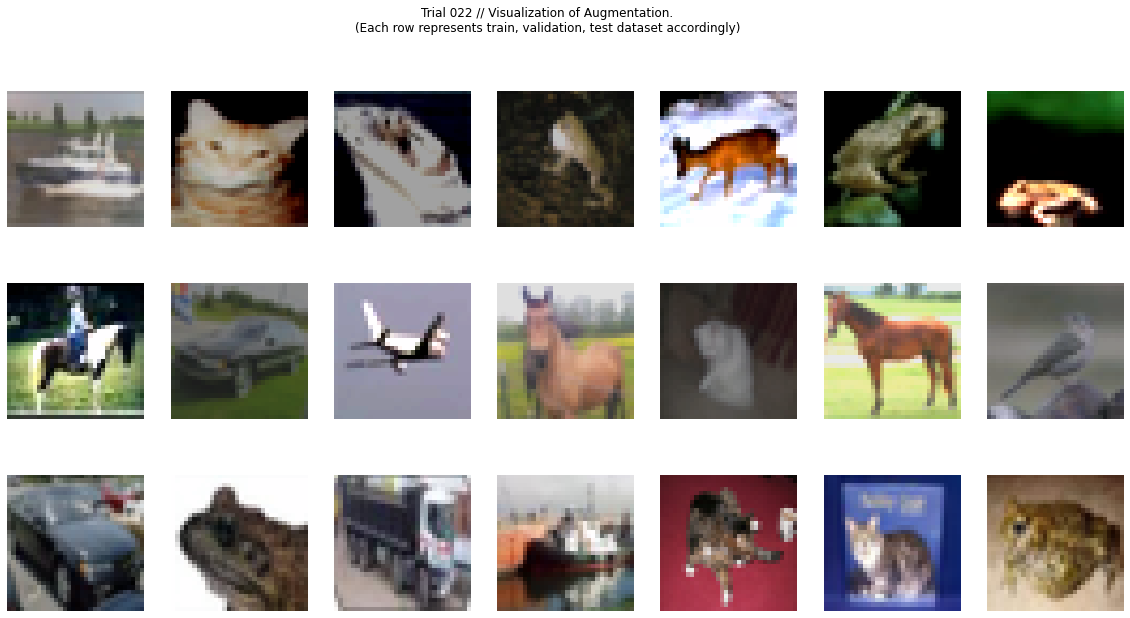

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.049, Acc: 23.39% F1(macro): 0.23: 100%|██████████| 156/156 [00:10<00:00, 14.26it/s]
 Val:       Loss: 1.886, Acc: 32.57% F1(macro): 0.31: 100%|██████████| 40/40 [00:02<00:00, 18.57it/s]


Model saved. Current best test f1: 0.308


Train: [002] Loss: 1.705, Acc: 37.17% F1(macro): 0.37: 100%|██████████| 156/156 [00:11<00:00, 13.67it/s]
 Val:       Loss: 1.596, Acc: 41.39% F1(macro): 0.40: 100%|██████████| 40/40 [00:02<00:00, 18.00it/s]


Model saved. Current best test f1: 0.403


Train: [003] Loss: 1.538, Acc: 43.46% F1(macro): 0.43: 100%|██████████| 156/156 [00:11<00:00, 14.01it/s]
 Val:       Loss: 1.468, Acc: 46.95% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 18.07it/s]


Model saved. Current best test f1: 0.462


Train: [004] Loss: 1.425, Acc: 47.93% F1(macro): 0.48: 100%|██████████| 156/156 [00:11<00:00, 13.96it/s]
 Val:       Loss: 1.452, Acc: 48.14% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 18.07it/s]


Model saved. Current best test f1: 0.470


Train: [005] Loss: 1.347, Acc: 51.39% F1(macro): 0.51: 100%|██████████| 156/156 [00:11<00:00, 13.89it/s]
 Val:       Loss: 1.324, Acc: 51.39% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.05it/s]


Model saved. Current best test f1: 0.508


Train: [006] Loss: 1.278, Acc: 53.99% F1(macro): 0.54:  58%|█████▊    | 90/156 [00:06<00:04, 14.84it/s] 


KeyboardInterrupt: 

In [9]:
study = optuna.create_study(direction="maximize", study_name="autoaug", load_if_exists=True)
study.optimize(objective, n_trials=100)